# Functions and Datasets

In [2]:
# @title Functions

import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset,random_split
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import copy
import gc
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


def compute_pixel_accuracy(pred, target, num_classes):
    """
    Compute Pixel Accuracy (PA) and Mean Pixel Accuracy (mPA)

    Args:
        pred: (B, C, H, W) or (B, H, W) - model outputs (logits or predicted indices)
        target: (B, H, W) - ground truth class indices
        num_classes: int

    Returns:
        pa: overall pixel accuracy
        mpa: mean per-class accuracy
    """
    # Convert logits to predicted class indices if necessary
    if pred.dim() == 4:  # (B, C, H, W)
        pred = torch.argmax(pred, dim=1)  # -> (B, H, W)

    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    total = 0
    correct = 0
    class_acc = np.zeros(num_classes)
    class_count = np.zeros(num_classes)

    for c in range(num_classes):
        c_mask = (target == c)
        class_count[c] = np.sum(c_mask)
        class_acc[c] = np.sum((pred == c) & c_mask)

    correct = np.sum(pred == target)
    total = target.size

    pa = correct / total
    mpa = np.mean(np.divide(class_acc, class_count, out=np.zeros_like(class_acc), where=class_count != 0))

    return pa, mpa

def extract_boundary(mask, dilation_ratio=0.02):
    """
    Extract boundary from binary or multi-class mask.

    Args:
        mask: (H, W) numpy array or torch tensor
        dilation_ratio: determines boundary width as a ratio of image size

    Returns:
        binary boundary mask (H, W)
    """
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    h, w = mask.shape[-2:]
    dilation = max(1, int(round(dilation_ratio * np.linalg.norm([h, w]))))

    boundary = np.zeros_like(mask, dtype=bool)

    for cls in np.unique(mask):
        if cls == 0:  # usually background
            continue
        region = (mask == cls)
        eroded = binary_dilation(region, iterations=dilation)
        boundary |= eroded ^ region  # XOR to get boundary band

    return boundary.astype(np.uint8)

def compute_biou(pred, target, dilation_ratio=0.02, num_classes=21):
    """
    Compute Boundary IoU between pred and target masks (support classification & regression).

    Args:
        pred: (B, H, W) or (B, C, H, W) logits or float maps
        target: (B, H, W) float or int
        dilation_ratio: width of boundary band as ratio of image size
        num_classes: maximum number of classes

    Returns:
        mean BIoU
    """
    # Classification logits → argmax
    if pred.ndim == 4 and pred.shape[1] > 1:
        pred = pred.argmax(dim=1)

    # Regression output (float)
    elif pred.dtype == torch.float32:
        pred = pred.round().long().clamp(0, num_classes - 1)

    if target.dtype == torch.float32:
        target = target.round().long().clamp(0, num_classes - 1)

    pred = pred.detach().cpu()
    target = target.detach().cpu()

    biou_list = []
    for i in range(pred.shape[0]):
        pred_b = extract_boundary(pred[i], dilation_ratio)
        target_b = extract_boundary(target[i], dilation_ratio)

        intersection = np.logical_and(pred_b, target_b).sum()
        union = np.logical_or(pred_b, target_b).sum()

        if union == 0:
            biou_list.append(float('nan'))
        else:
            biou_list.append(intersection / union)

    return np.nanmean(biou_list)





def compute_miou(pred, target, num_classes=21):
    """
    Compute mean Intersection over Union (mIoU)

    Args:
        pred: Tensor of shape (B, H, W) or (B, C, H, W)
              - (B, H, W): predictions with class indices or regression output (after rounding)
              - (B, C, H, W): classification logits, will apply argmax over dim=1
        target: Tensor of shape (B, H, W), ground truth class indices
        num_classes: Total number of classes to compute IoU over

    Returns:
        mean IoU across all classes (float)
    """

    # Convert classification logits to label indices
    if pred.dim() == 4:
        pred = torch.argmax(pred, dim=1)

    pred = pred.detach().cpu().long().numpy()
    target = target.detach().cpu().long().numpy()

    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            ious.append(float('nan'))  # Optional: 1.0 if you prefer to ignore empty classes
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)



class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        """
        Args:
            patience (int): 连续多少个 epoch 没有提升就停止
            min_delta (float): 最小改善幅度，低于该值视为没有改善
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.bn = nn.BatchNorm2d(out_channels)
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #print('x',x.shape)
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.fft.rfft(x, 2, normalized=True, onesided=True)#old version
        x_ft = torch.fft.rfft2(x)#new version

        # Multiply relevant Fourier modes
        #print('x_ft',x_ft.shape)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))#old version
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))#new version
        x = self.bn(x)
        return x
class LayerRegressionDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = torch.from_numpy(x_data).float()  # (B, 5, 256)
        self.y = torch.from_numpy(y_data).float()  # (B, 15, 256)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
def plot_all_losses(train_losses, val_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_layer_on_canvas(layer_input, layer_output, layer_pred, canvas_height=1000, canvas_width=256):
    """
    layer_input: (5, 256)
    layer_output: (15, 256)
    layer_pred: (15, 256)
    canvas: (1000, 256)
    """

    # 创建空白背景
    canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255  # white

    plt.figure(figsize=(12, 6))
    plt.imshow(canvas, extent=[0, canvas_width, canvas_height, 0])  # extent 保持坐标一致
    plt.xlim(0, canvas_width)
    plt.ylim(canvas_height, 0)  # 反转 Y 轴

    # Plot input layers (Red)
    for m in range(layer_input.shape[0]):
        plt.plot(range(canvas_width), layer_input[m], color='red', linewidth=1, label='Input' if m == 0 else "")

    # Plot output layers (Blue)
    for m in range(layer_output.shape[0]):
        plt.plot(range(canvas_width), layer_output[m], color='blue', linewidth=1, linestyle='--', label='Ground Truth' if m == 0 else "")

    # Plot predicted layers (Green)
    for m in range(layer_pred.shape[0]):
        plt.plot(range(canvas_width), layer_pred[m], color='green', linewidth=1, linestyle=':', label='Prediction' if m == 0 else "")

    plt.legend()
    plt.title("Input (Red), Output (Blue), Prediction (Green)")
    plt.xlabel("Column (n)")
    plt.ylabel("Depth / Height")
    plt.axis("on")  # 你也可以 plt.axis("off") 只保留图像
    plt.tight_layout()
    plt.show()

def visualize_sample_reg(model, dataloader, device, max_samples=3):
    model.eval()
    shown = 0

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()     # (B, 1, H, W)
            images = xb.cpu().numpy()
            labels = yb.cpu().numpy()

            B = xb.shape[0]
            for i in range(B):
                pred = preds[i]   # (H, W)
                image = images[i][0]
                label = labels[i][0]

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap='gray')
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(label, cmap='tab20', vmin=0, vmax=20)
                #plt.imshow(label, vmin=0, vmax=20)
                plt.title("Ground Truth (Regression)")
                plt.colorbar()
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap='tab20', vmin=0, vmax=20)
                #plt.imshow(pred,  vmin=0, vmax=20)
                plt.title("Predicted (Regression)")
                plt.colorbar()
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                shown += 1
                if shown >= max_samples:
                    return

def visualize_fusion_sample_reg(model, dataloader, device, max_samples=3):
    model.eval()
    shown = 0

    with torch.no_grad():
        for xb_img, xb_layer, yb in dataloader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1).float()
            preds = model(xb_img, xb_layer).cpu().numpy()  # (B, num_classes, H, W)
            images = xb_img.cpu().numpy()
            labels = yb.cpu().numpy()

            B = xb_img.shape[0]
            for i in range(B):
                pred = preds[i]   # (H, W)
                image = images[i][0]
                label = labels[i]

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap='gray')
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(label, cmap='tab20', vmin=0, vmax=20)
                #plt.imshow(label, vmin=0, vmax=20)
                plt.title("Ground Truth (Regression)")
                plt.colorbar()
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap='tab20', vmin=0, vmax=20)
                #plt.imshow(pred,  vmin=0, vmax=20)
                plt.title("Predicted (Regression)")
                plt.colorbar()
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                shown += 1
                if shown >= max_samples:
                    return
def visualize_fusion_sample_cls(model, dataloader, device, num_classes=21, max_samples=3):
    model.eval()
    shown = 0

    with torch.no_grad():
        for xb_img, xb_layer, yb in dataloader:
            xb_img, xb_layer = xb_img.to(device), xb_layer.to(device)
            preds = model(xb_img, xb_layer)  # (B, num_classes, H, W)

            # Get class predictions
            preds = torch.argmax(preds, dim=1).cpu().numpy()  # (B, H, W)
            images = xb_img[:, 0].cpu().numpy()               # (B, H, W) - take channel 0
            labels = yb.squeeze(1).cpu().numpy()              # (B, H, W)

            B = xb_img.shape[0]
            for i in range(B):
                pred = preds[i]
                image = images[i]
                label = labels[i]

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap='gray')
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(label, cmap='tab20', vmin=0, vmax=num_classes - 1)
                plt.title("Ground Truth (Class)")
                plt.colorbar()
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap='tab20', vmin=0, vmax=num_classes - 1)
                plt.title("Predicted (Class)")
                plt.colorbar()
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                shown += 1
                if shown >= max_samples:
                    return


def visualize_sample(model, dataloader, device, num_classes=21, max_samples=3):
    model.eval()
    cmap = plt.get_cmap("tab20")  # 用 20 种颜色，够用

    with torch.no_grad():
        for i, (xb, yb) in enumerate(dataloader):
            xb = xb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1).cpu().numpy()[0]      # (H, W)
            image = xb.cpu().numpy()[0, 0]                            # (H, W)
            label = yb.numpy()[0, 0]                                  # (H, W)

            # Plot
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(label, cmap=cmap, vmin=0, vmax=num_classes - 1)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred, cmap=cmap, vmin=0, vmax=num_classes - 1)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            if i + 1 >= max_samples:
                break






class FusionDataset1(Dataset):
    def __init__(self, data, mask, layer_x, H):
        """
        data: numpy array (N, 1, H, W)
        mask: numpy array (N, 1, H, W)
        layer_x: numpy array (N, 5, W)
        H: height of the image
        """
        self.data = torch.from_numpy(data).float()
        self.mask = torch.from_numpy(mask).long()
        self.layer_x = torch.from_numpy(layer_x).float()
        self.H = H

    def __len__(self):
        return self.data.shape[0]

    def layer_coords_to_mask(self, layer_coords):
        # layer_coords: (5, W)
        num_layers, W = layer_coords.shape
        layer_mask = torch.zeros((num_layers, self.H, W), dtype=torch.float32)

        for l in range(num_layers):
            for w in range(W):
                h_idx = int(layer_coords[l, w].item())
                h_idx = max(0, min(self.H - 1, h_idx))
                layer_mask[l, h_idx, w] = 1.0

        return layer_mask

    def __getitem__(self, idx):
        img = self.data[idx]     # (1, H, W)
        mask = self.mask[idx]    # (1, H, W)
        layer_coords = self.layer_x[idx]  # (5, W)

        # Convert to mask (5, H, W)
        layer_mask = self.layer_coords_to_mask(layer_coords)

        # Fuse
        fused_input = torch.cat([img, layer_mask], dim=0)  # (6, H, W)

        return fused_input, mask



class SegmentationDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.x[idx])              # (1, H, W), float32
        label = torch.from_numpy(self.y[idx]).long()       # (1, H, W), long
        return image, label






In [3]:
# @title Datasets
#MAT_PATH = r"/content/drive/MyDrive/dataset/small_subset.mat"
NUM_CLASSES = 21
EPOCHS = 200
BATCH_SIZE = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
Random_state = 42
PATIENCE = 200
MIN_DELTA = 5e-4
'''
MAT_PATH = r"/content/drive/MyDrive/dataset/processed_data_part1.mat"
with h5py.File(MAT_PATH, "r") as f:
    data = np.array(f["Data"]).astype(np.float32)         # shape: (N, H, W)
    mask = np.clip(np.array(f["SegmentBitmap"]).astype(np.int64), 0, 20)  # shape: (N, H, W), values in [0, 20]
    layer_data = np.array(f["LayersVector"]).astype(np.float32)         # shape: (N, 256, 20)
'''
base_path = r"D:\download\processed_data_part"
num_parts = 3  # Number of separate .mat files

# Initialize temporary storage lists
data_list = []
mask_list = []
layer_list = []

# Loop over each file and extract arrays
for i in range(1, num_parts + 1):
    path = f"{base_path}{i}.mat"
    with h5py.File(path, "r") as f:
        # Load and cast each dataset
        data = np.array(f["Data"]).astype(np.float32)  # (N, H, W)
        mask = np.clip(np.array(f["SegmentBitmap"]).astype(np.int64), 0, 20)  # clamp to [0, 20]
        layers = np.array(f["LayersVector"]).astype(np.float32)  # (N, 256, 20)

        # Append to list
        data_list.append(data)
        mask_list.append(mask)
        layer_list.append(layers)

# Concatenate all parts along the batch dimension
data = np.concatenate(data_list, axis=0)    # Final shape: (N_total, H, W)
mask = np.concatenate(mask_list, axis=0)    # Final shape: (N_total, H, W)
layer_data = np.concatenate(layer_list, axis=0)  # Final shape: (N_total, 256, 20)


# Add channel dimension
data = data[:, np.newaxis, :, :]  # shape: (N, 1, H, W)
mask = mask[:, np.newaxis, :, :]  # shape: (N, 1, H, W)
print(np.unique(mask))

layer_x = layer_data[:,0:5,:]#input
layer_y = layer_data[:,5:20,:]#output



cuda
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


# Semantic Segmentation

In [5]:
# @title Dataset

x_temp, x_test, y_temp, y_test = train_test_split(data, mask, test_size=0.2, random_state=Random_state)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=Random_state)  # 0.25 * 0.8 = 0.2

train_loader = DataLoader(SegmentationDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SegmentationDataset(x_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(SegmentationDataset(x_test, y_test), batch_size=BATCH_SIZE)

[Epoch 1/200] Train Loss: 2.8112, Val Loss: 2.4514，Test Loss: 2.4532, miou:0.0771,pa:0.1833,mpa:0.1822
[Epoch 1] New best model saved (Val Loss: 2.4514)
[Epoch 2/200] Train Loss: 2.2594, Val Loss: 2.1213，Test Loss: 2.1225, miou:0.1260,pa:0.2312,mpa:0.2170
[Epoch 2] New best model saved (Val Loss: 2.1213)
[Epoch 3/200] Train Loss: 2.0538, Val Loss: 2.0015，Test Loss: 2.0002, miou:0.1550,pa:0.2578,mpa:0.2600
[Epoch 3] New best model saved (Val Loss: 2.0015)
[Epoch 4/200] Train Loss: 1.9510, Val Loss: 1.9165，Test Loss: 1.9109, miou:0.1772,pa:0.2816,mpa:0.2939
[Epoch 4] New best model saved (Val Loss: 1.9165)
[Epoch 5/200] Train Loss: 1.8918, Val Loss: 1.8693，Test Loss: 1.8614, miou:0.2015,pa:0.3139,mpa:0.3112
[Epoch 5] New best model saved (Val Loss: 1.8693)
[Epoch 6/200] Train Loss: 1.8466, Val Loss: 1.8470，Test Loss: 1.8374, miou:0.2020,pa:0.3158,mpa:0.3138
[Epoch 6] New best model saved (Val Loss: 1.8470)
[Epoch 7/200] Train Loss: 1.8277, Val Loss: 1.8218，Test Loss: 1.8152, miou:0.2080,

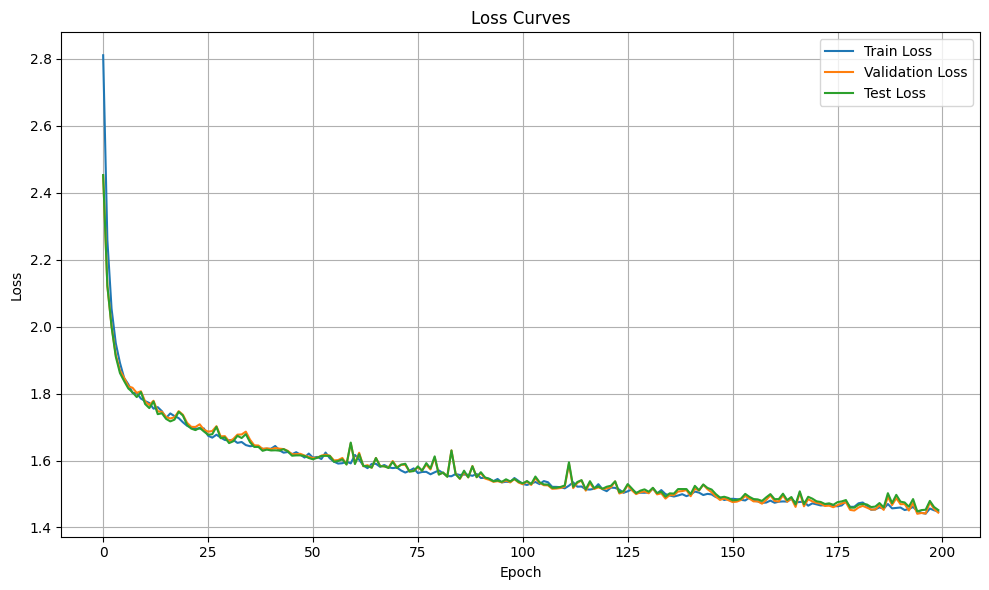

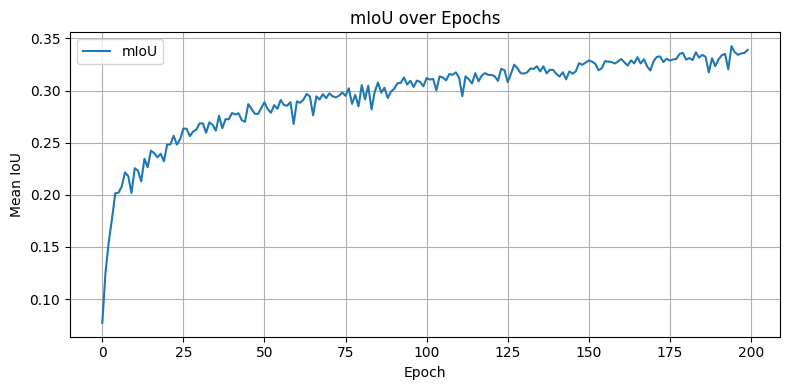

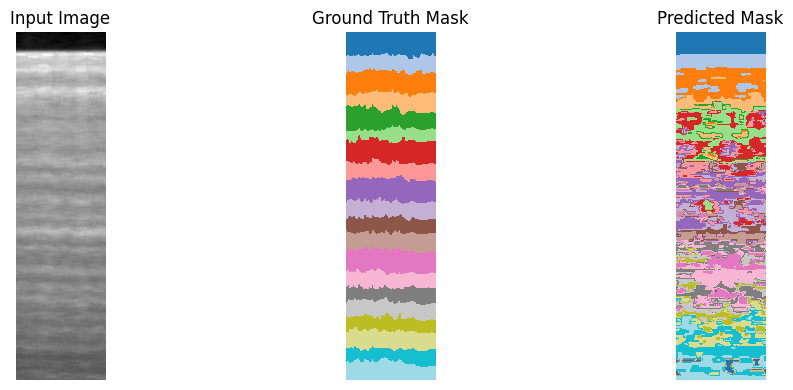

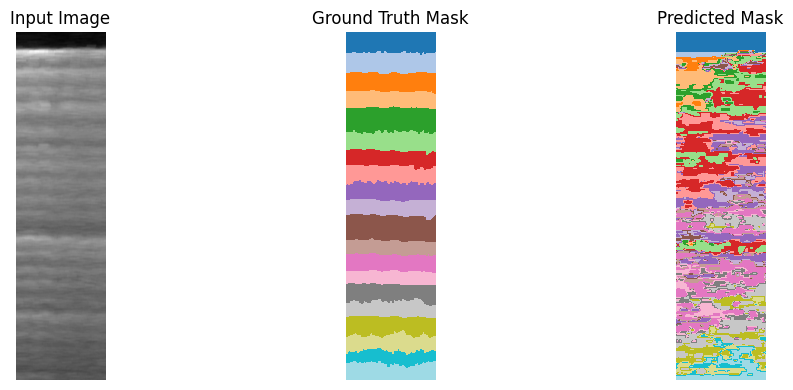

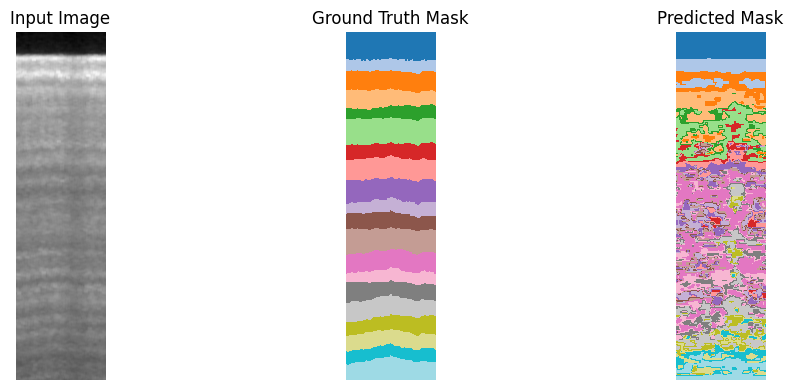

In [6]:
# @title Simple CNN Classification
class SimpleSegNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

        )
        self.decoder = nn.Sequential(

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, num_classes, 1)  # logits for all classes
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

# === TRAINING LOOP ===
model = SimpleSegNet(NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []
best_val_loss = float('inf')
best_model_state = None
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    #biou_total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        #print(pred.shape,yb.shape)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            test_loss += loss.item()
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)

            pa_total += pa
            mpa_total += mpa
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output
            #biou = compute_biou(pred, yb)
            #biou_total += biou
            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    #biou = biou_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)
    #biou_curve.append(biou)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")

plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

visualize_sample(model, test_loader, DEVICE, num_classes=NUM_CLASSES, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 61.1642, Val Loss: 27.4004，Test Loss: 27.3146, miou:0.0068,pa:0.0000,mpa:0.0000
[Epoch 1] New best model saved (Val Loss: 27.4004)
[Epoch 2/200] Train Loss: 12.6206, Val Loss: 8.8966，Test Loss: 9.0503, miou:0.0925,pa:0.0000,mpa:0.0000
[Epoch 2] New best model saved (Val Loss: 8.8966)
[Epoch 3/200] Train Loss: 8.4032, Val Loss: 8.0599，Test Loss: 8.2501, miou:0.1065,pa:0.0000,mpa:0.0000
[Epoch 3] New best model saved (Val Loss: 8.0599)
[Epoch 4/200] Train Loss: 7.6987, Val Loss: 7.2779，Test Loss: 7.3596, miou:0.1224,pa:0.0000,mpa:0.0000
[Epoch 4] New best model saved (Val Loss: 7.2779)
[Epoch 5/200] Train Loss: 6.7412, Val Loss: 6.3915，Test Loss: 6.4723, miou:0.1137,pa:0.0000,mpa:0.0000
[Epoch 5] New best model saved (Val Loss: 6.3915)
[Epoch 6/200] Train Loss: 6.2061, Val Loss: 7.0573，Test Loss: 7.1657, miou:0.0890,pa:0.0000,mpa:0.0000
[Epoch 7/200] Train Loss: 6.0705, Val Loss: 5.7452，Test Loss: 5.7806, miou:0.1207,pa:0.0000,mpa:0.0000
[Epoch 7] New best model

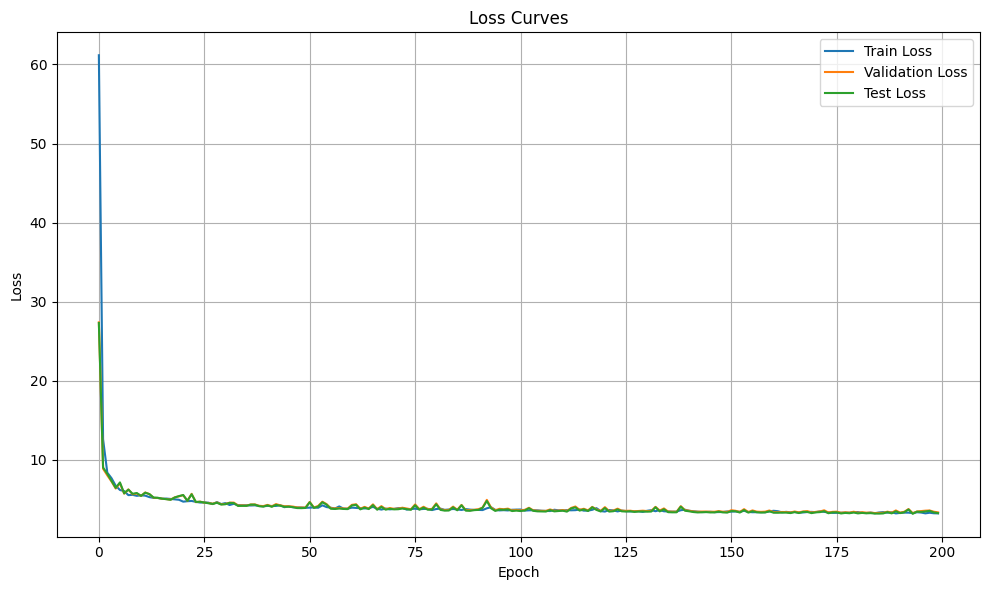

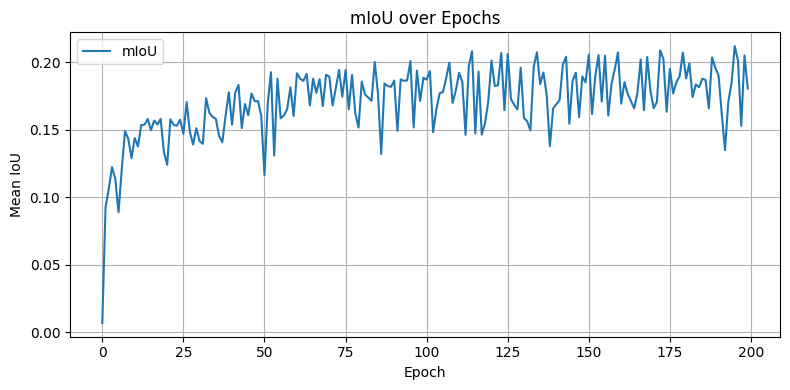

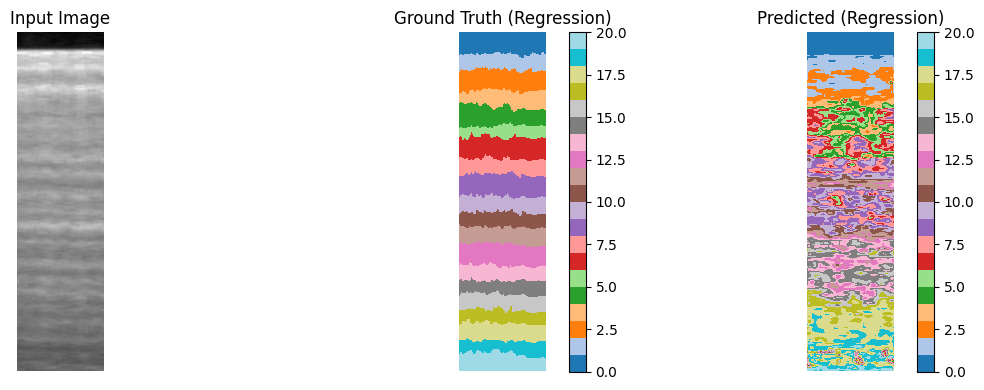

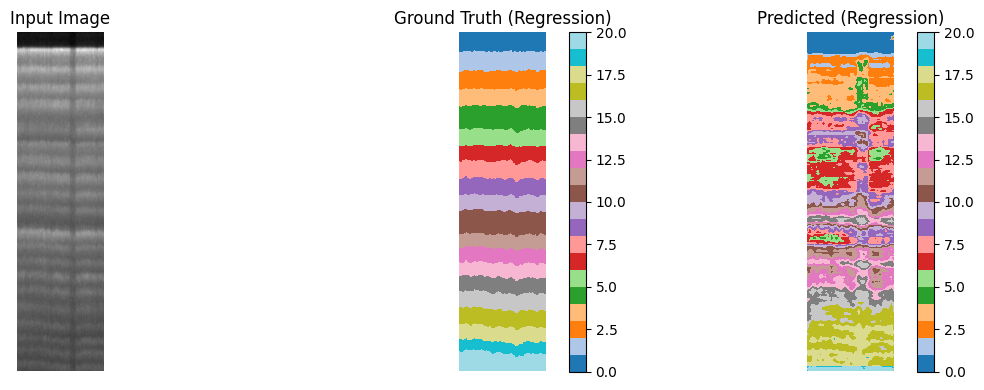

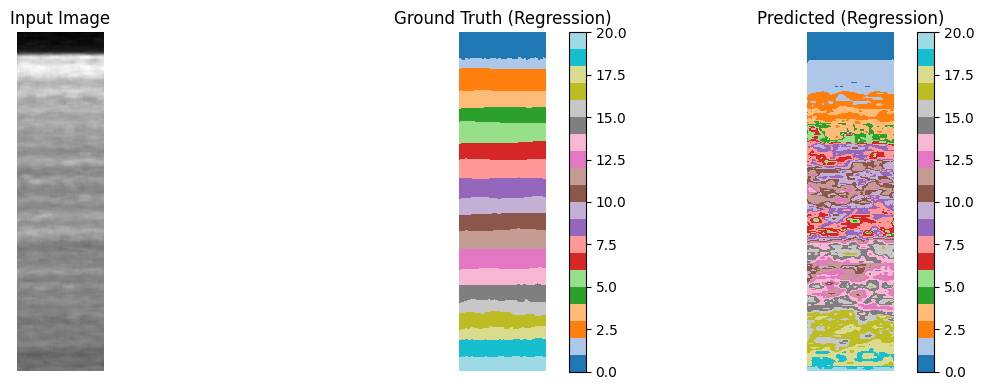

In [7]:
# @title Simple CNN Regression

class SimpleSegNet(nn.Module):
    def __init__(self):
        super(SimpleSegNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 1, 1)  # 回归输出，1 通道，float 值
        )

    def forward(self, x):
        x = self.decoder(self.encoder(x))  # (B, 1, H, W)
        return x.squeeze(1)



model = SimpleSegNet().to(DEVICE)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1).float()  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0
    val_count = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            #print(f"PA: {pa:.4f}, mPA: {mpa:.4f}")
            pa_total += pa
            mpa_total += mpa

            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")



plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
visualize_sample_reg(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 2.4696, Val Loss: 2.6072，Test Loss: 2.6021, miou:0.0950,pa:0.1958,mpa:0.1820
[Epoch 1] New best model saved (Val Loss: 2.6072)
[Epoch 2/200] Train Loss: 2.0844, Val Loss: 2.0509，Test Loss: 2.0481, miou:0.1931,pa:0.3047,mpa:0.3064
[Epoch 2] New best model saved (Val Loss: 2.0509)
[Epoch 3/200] Train Loss: 1.8960, Val Loss: 1.8816，Test Loss: 1.8773, miou:0.2195,pa:0.3412,mpa:0.3409
[Epoch 3] New best model saved (Val Loss: 1.8816)
[Epoch 4/200] Train Loss: 1.7970, Val Loss: 1.7909，Test Loss: 1.7915, miou:0.2371,pa:0.3580,mpa:0.3623
[Epoch 4] New best model saved (Val Loss: 1.7909)
[Epoch 5/200] Train Loss: 1.7367, Val Loss: 1.7989，Test Loss: 1.7922, miou:0.2439,pa:0.3610,mpa:0.3636
[Epoch 6/200] Train Loss: 1.7075, Val Loss: 1.7111，Test Loss: 1.7110, miou:0.2624,pa:0.3810,mpa:0.3885
[Epoch 6] New best model saved (Val Loss: 1.7111)
[Epoch 7/200] Train Loss: 1.6744, Val Loss: 1.6722，Test Loss: 1.6737, miou:0.2672,pa:0.3910,mpa:0.3915
[Epoch 7] New best model save

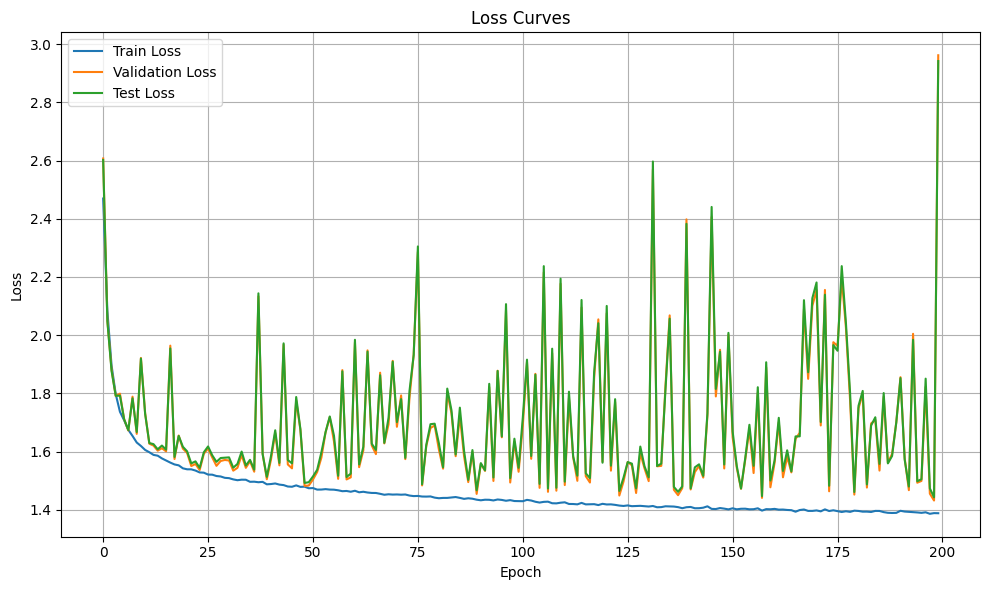

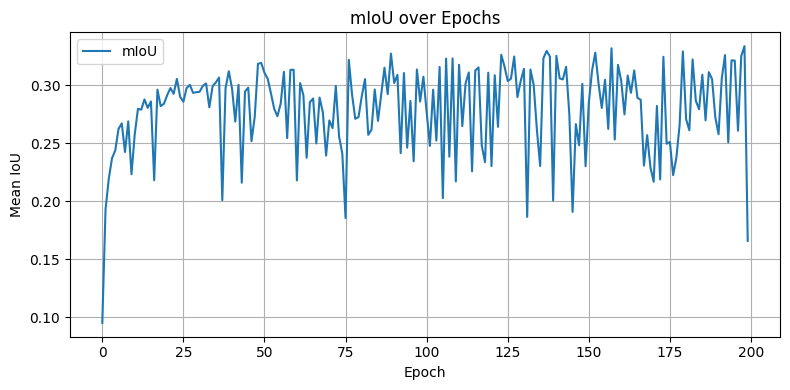

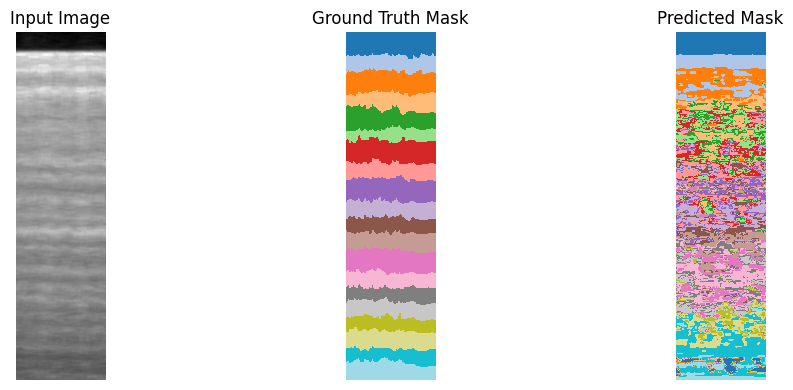

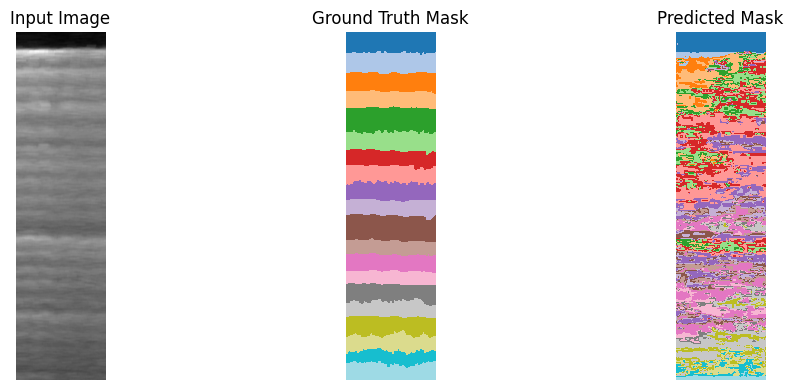

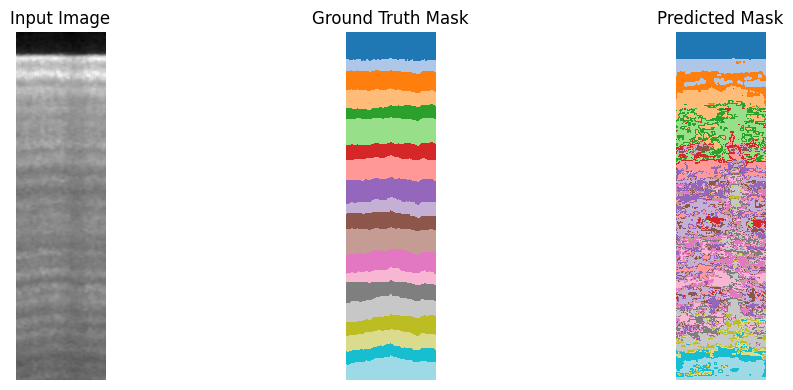

In [8]:
# @title Simple Unet Classification


class UNetLite(nn.Module):
    def __init__(self, num_classes):
        super(UNetLite, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(16)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64)
        )
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32)
        )

        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(16)
        )

        self.up0 = nn.Upsample(scale_factor=2, mode='nearest')
        self.final = nn.Conv2d(16, num_classes, 1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)         # -> (B, 16, H, W)
        x2 = self.enc2(self.pool(x1))  # -> (B, 32, H/2, W/2)
        x3 = self.enc3(self.pool(x2))  # -> (B, 64, H/4, W/4)

        # Decoder
        u2 = self.up2(x3)                 # (B, 64, H/2, W/2)
        d2 = self.dec2(torch.cat([u2, x2], dim=1))  # skip connection

        u1 = self.up1(d2)                 # (B, 32, H, W)
        d1 = self.dec1(torch.cat([u1, x1], dim=1))  # skip


        out = self.final(d1)

        return out


model = UNetLite(NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []
best_val_loss = float('inf')
best_model_state = None
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    #biou_total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        #print(pred.shape,yb.shape)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            test_loss += loss.item()
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)

            pa_total += pa
            mpa_total += mpa
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output
            #biou = compute_biou(pred, yb)
            #biou_total += biou
            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    #biou = biou_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)
    #biou_curve.append(biou)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")

plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

visualize_sample(model, test_loader, DEVICE, num_classes=NUM_CLASSES, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 63.1287, Val Loss: 25.3281，Test Loss: 25.1756, miou:0.0139,pa:0.0000,mpa:0.0000
[Epoch 1] New best model saved (Val Loss: 25.3281)
[Epoch 2/200] Train Loss: 16.7017, Val Loss: 10.9264，Test Loss: 10.9674, miou:0.0828,pa:0.0000,mpa:0.0000
[Epoch 2] New best model saved (Val Loss: 10.9264)
[Epoch 3/200] Train Loss: 9.3567, Val Loss: 9.4100，Test Loss: 9.5641, miou:0.1046,pa:0.0000,mpa:0.0000
[Epoch 3] New best model saved (Val Loss: 9.4100)
[Epoch 4/200] Train Loss: 8.9004, Val Loss: 9.0261，Test Loss: 9.1669, miou:0.1080,pa:0.0000,mpa:0.0000
[Epoch 4] New best model saved (Val Loss: 9.0261)
[Epoch 5/200] Train Loss: 8.3238, Val Loss: 8.4321，Test Loss: 8.5413, miou:0.1156,pa:0.0000,mpa:0.0000
[Epoch 5] New best model saved (Val Loss: 8.4321)
[Epoch 6/200] Train Loss: 7.7677, Val Loss: 7.6019，Test Loss: 7.7406, miou:0.1250,pa:0.0000,mpa:0.0000
[Epoch 6] New best model saved (Val Loss: 7.6019)
[Epoch 7/200] Train Loss: 7.3022, Val Loss: 8.2472，Test Loss: 8.4193, miou

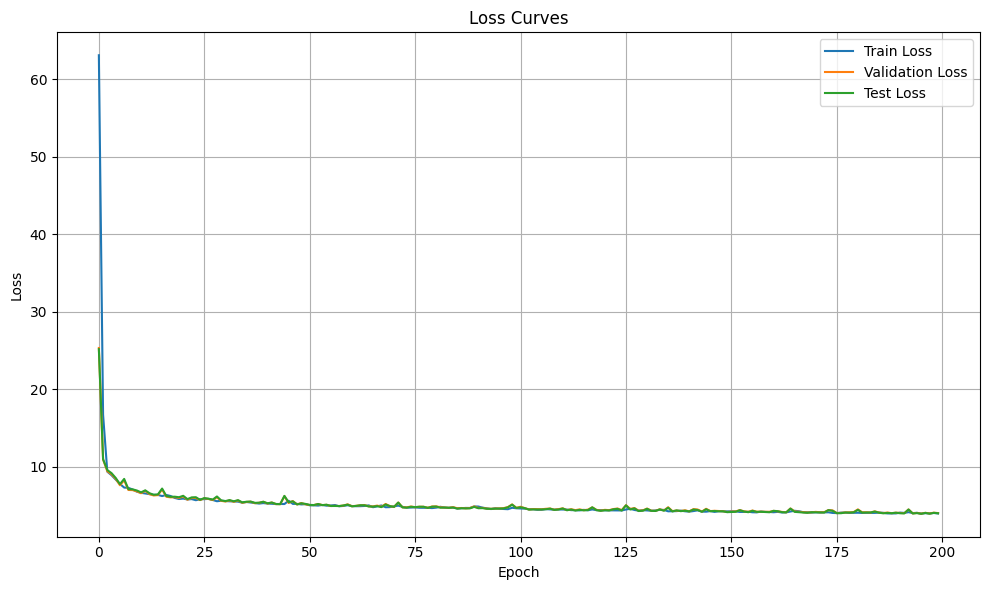

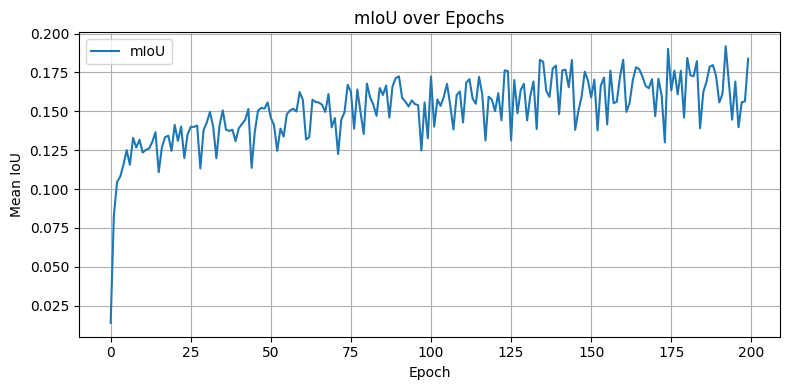

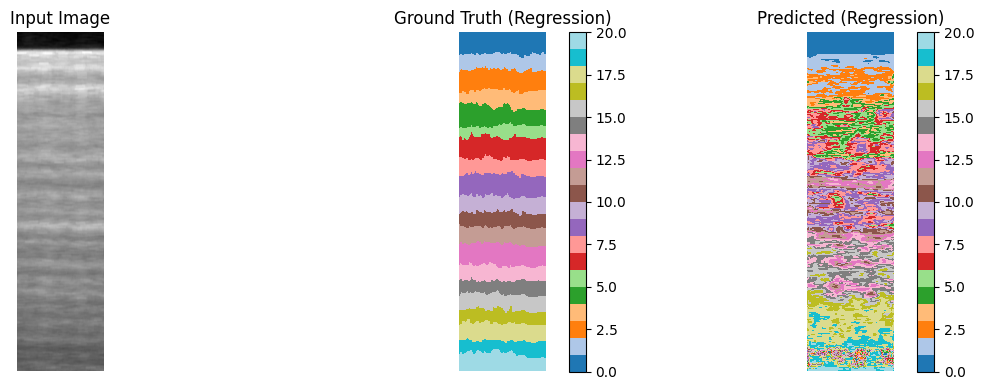

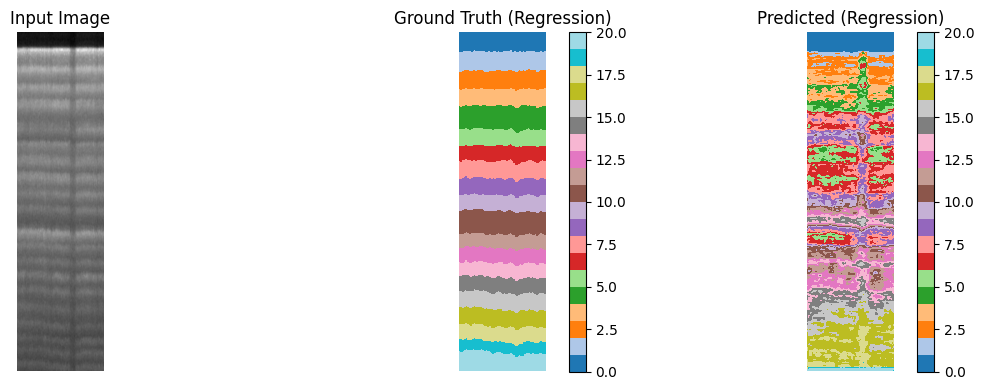

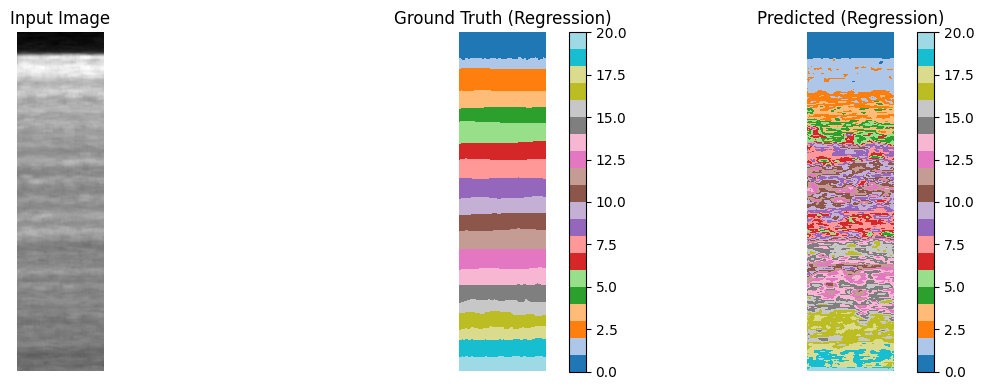

In [9]:
# @title Simple Unet Regression
class UNetLite(nn.Module):
    def __init__(self):
        super(UNetLite, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, 3, padding=1), nn.ReLU()
        )

        self.up0 = nn.Upsample(scale_factor=2, mode='nearest')
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)         # -> (B, 16, H, W)
        x2 = self.enc2(self.pool(x1))  # -> (B, 32, H/2, W/2)
        x3 = self.enc3(self.pool(x2))  # -> (B, 64, H/4, W/4)

        # Decoder
        u2 = self.up2(x3)                 # (B, 64, H/2, W/2)
        d2 = self.dec2(torch.cat([u2, x2], dim=1))  # skip connection

        u1 = self.up1(d2)                 # (B, 32, H, W)
        d1 = self.dec1(torch.cat([u1, x1], dim=1))  # skip


        out = self.final(d1)

        return out.squeeze(1)


model = UNetLite().to(DEVICE)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1).float()  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0
    val_count = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            #print(f"PA: {pa:.4f}, mPA: {mpa:.4f}")
            pa_total += pa
            mpa_total += mpa

            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")



plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
visualize_sample_reg(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 1.1332, Val Loss: 1.8927，Test Loss: 1.8904, miou:0.6018,pa:0.7761,mpa:0.7317
[Epoch 1] New best model saved (Val Loss: 1.8927)
[Epoch 2/200] Train Loss: 0.3377, Val Loss: 0.2895，Test Loss: 0.2945, miou:0.7909,pa:0.8978,mpa:0.8729
[Epoch 2] New best model saved (Val Loss: 0.2895)
[Epoch 3/200] Train Loss: 0.2499, Val Loss: 0.2570，Test Loss: 0.2580, miou:0.8030,pa:0.9025,mpa:0.8828
[Epoch 3] New best model saved (Val Loss: 0.2570)
[Epoch 4/200] Train Loss: 0.2217, Val Loss: 0.2413，Test Loss: 0.2421, miou:0.8146,pa:0.9078,mpa:0.8971
[Epoch 4] New best model saved (Val Loss: 0.2413)
[Epoch 5/200] Train Loss: 0.2082, Val Loss: 0.2179，Test Loss: 0.2175, miou:0.8243,pa:0.9143,mpa:0.8976
[Epoch 5] New best model saved (Val Loss: 0.2179)
[Epoch 6/200] Train Loss: 0.1893, Val Loss: 0.2236，Test Loss: 0.2226, miou:0.8222,pa:0.9119,mpa:0.8987
[Epoch 7/200] Train Loss: 0.1796, Val Loss: 0.1943，Test Loss: 0.1928, miou:0.8390,pa:0.9229,mpa:0.9063
[Epoch 7] New best model save

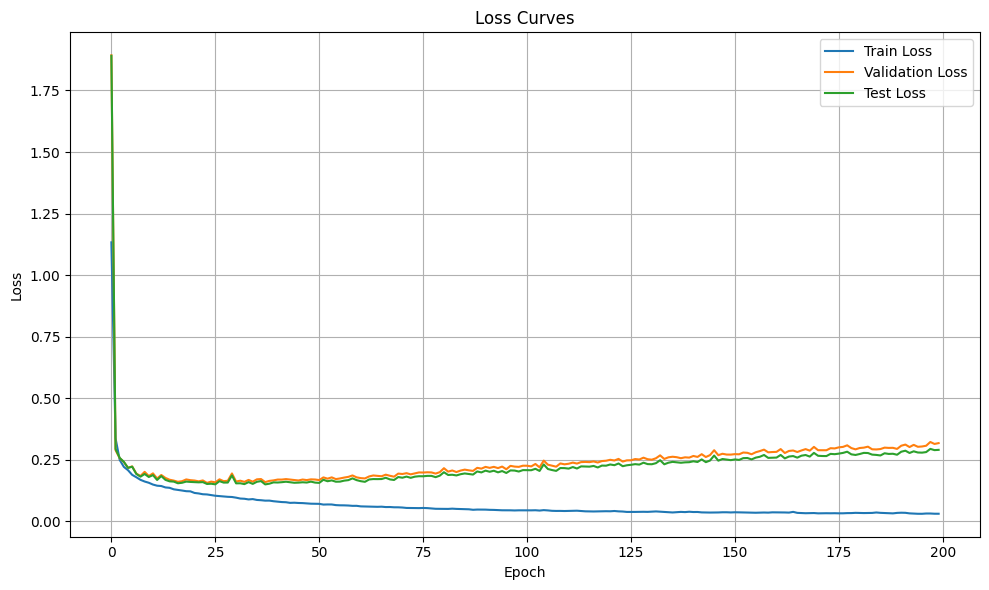

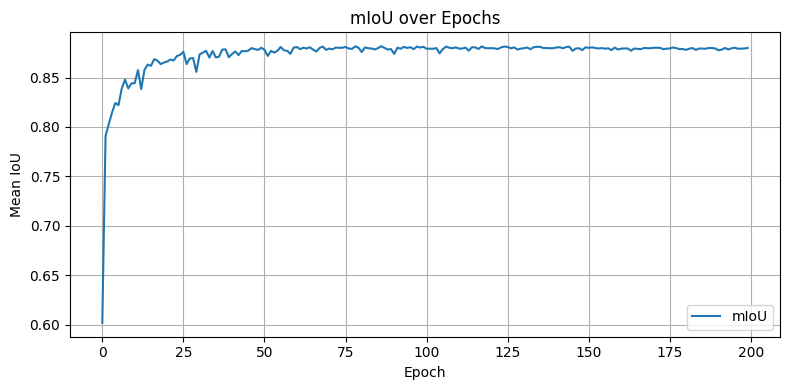

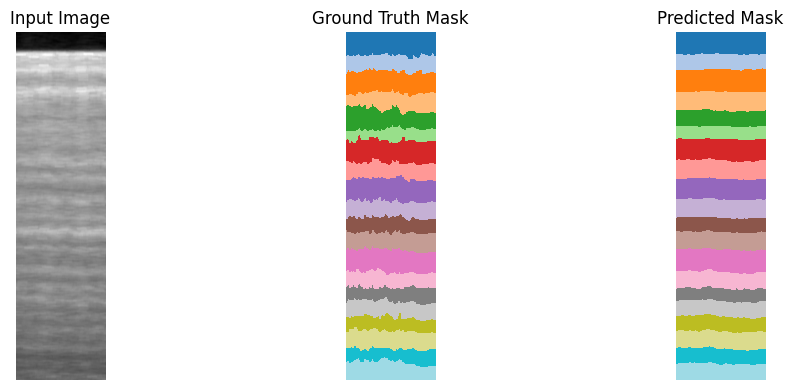

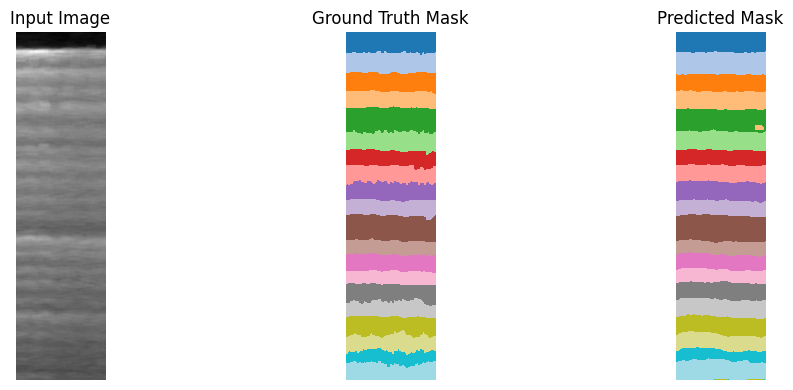

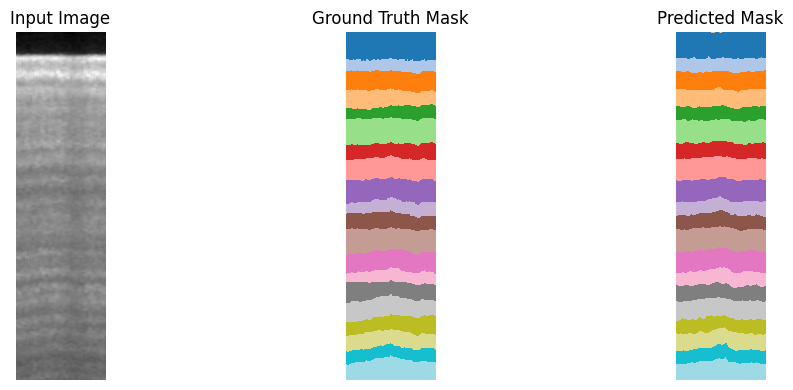

In [10]:
# @title Simple FNO Classification

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.bn = nn.BatchNorm2d(out_channels)
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #print('x',x.shape)
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.fft.rfft(x, 2, normalized=True, onesided=True)#old version
        x_ft = torch.fft.rfft2(x)#new version

        # Multiply relevant Fourier modes
        #print('x_ft',x_ft.shape)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))#old version
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))#new version
        x = self.bn(x)
        return x

class SimpleFNOBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, width):
        super(SimpleFNOBlock2d, self).__init__()
        self.width = width
        self.in_proj = nn.Conv2d(in_channels, width, 1)  # Lift to width channels

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)


        self.out_proj = nn.Conv2d(width, out_channels, 1)  # Back to 21 channel for classification

    def forward(self, x):
        x = self.in_proj(x)  # (B, width, H, W)

        x1 = self.conv0(x) + self.w0(x)
        x = F.relu(x1)

        x1 = self.conv1(x) + self.w1(x)
        x = F.relu(x1)

        x1 = self.conv2(x) + self.w2(x)
        x = F.relu(x1)


        out = self.out_proj(x)  # (B, 21, H, W)

        return out


model = SimpleFNOBlock2d(in_channels=1, out_channels=NUM_CLASSES, modes1=16, modes2=16, width=32).to(DEVICE)


loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []
best_val_loss = float('inf')
best_model_state = None
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    #biou_total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        #print(pred.shape,yb.shape)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            test_loss += loss.item()
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)

            pa_total += pa
            mpa_total += mpa
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output
            #biou = compute_biou(pred, yb)
            #biou_total += biou
            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    #biou = biou_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)
    #biou_curve.append(biou)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")

plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

visualize_sample(model, test_loader, DEVICE, num_classes=NUM_CLASSES, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 75.3009, Val Loss: 48.7215，Test Loss: 48.5950, miou:0.0185,pa:0.0000,mpa:0.0000
[Epoch 1] New best model saved (Val Loss: 48.7215)
[Epoch 2/200] Train Loss: 4.2721, Val Loss: 1.9028，Test Loss: 1.9133, miou:0.1764,pa:0.0000,mpa:0.0000
[Epoch 2] New best model saved (Val Loss: 1.9028)
[Epoch 3/200] Train Loss: 1.2806, Val Loss: 1.2080，Test Loss: 1.2256, miou:0.3068,pa:0.0000,mpa:0.0000
[Epoch 3] New best model saved (Val Loss: 1.2080)
[Epoch 4/200] Train Loss: 0.9289, Val Loss: 0.9520，Test Loss: 0.9670, miou:0.2231,pa:0.0000,mpa:0.0000
[Epoch 4] New best model saved (Val Loss: 0.9520)
[Epoch 5/200] Train Loss: 0.7662, Val Loss: 0.7776，Test Loss: 0.7979, miou:0.2294,pa:0.0000,mpa:0.0000
[Epoch 5] New best model saved (Val Loss: 0.7776)
[Epoch 6/200] Train Loss: 0.6476, Val Loss: 0.6961，Test Loss: 0.7178, miou:0.2711,pa:0.0000,mpa:0.0000
[Epoch 6] New best model saved (Val Loss: 0.6961)
[Epoch 7/200] Train Loss: 0.5546, Val Loss: 0.6146，Test Loss: 0.6336, miou:0.4

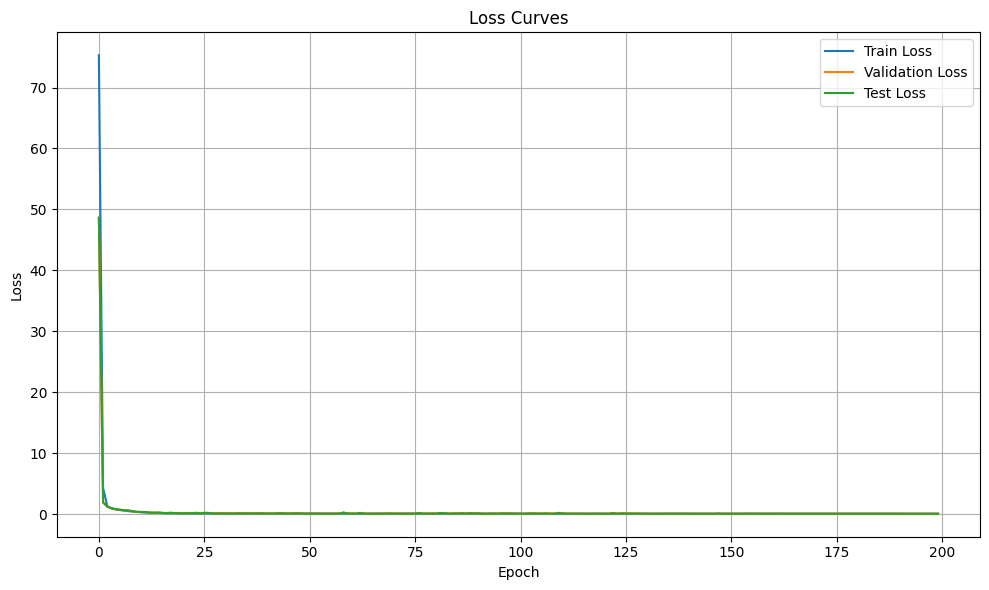

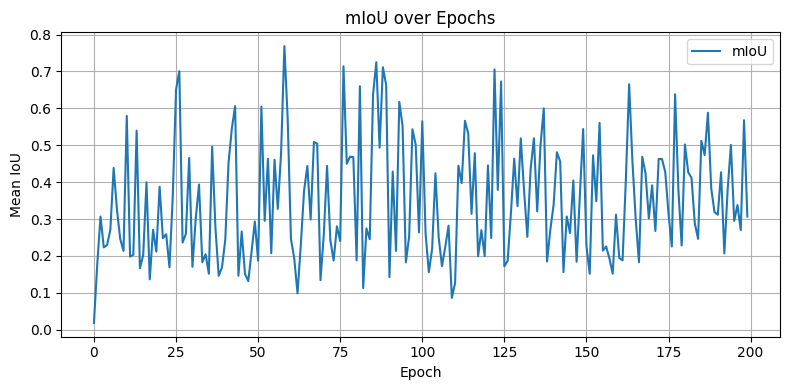

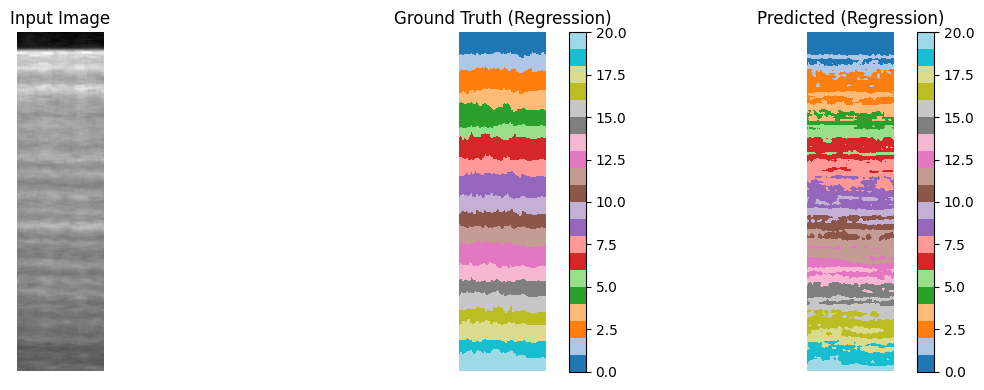

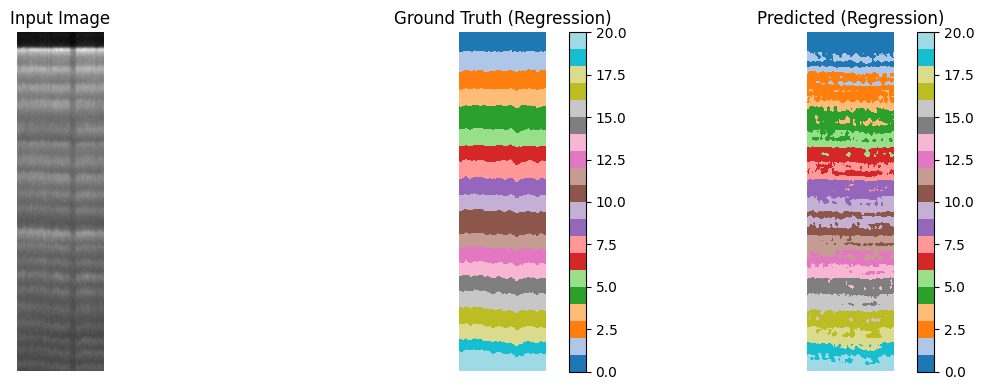

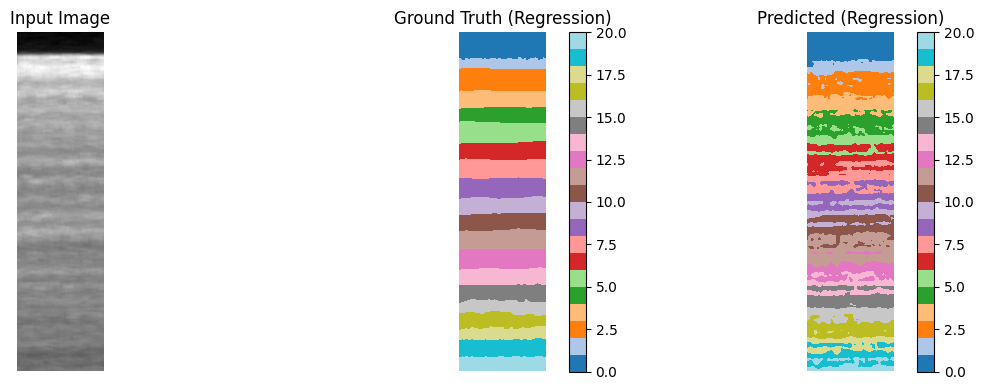

In [11]:
# @title Simple FNO Regression

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.bn = nn.BatchNorm2d(out_channels)
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #print('x',x.shape)
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.fft.rfft(x, 2, normalized=True, onesided=True)#old version
        x_ft = torch.fft.rfft2(x)#new version

        # Multiply relevant Fourier modes
        #print('x_ft',x_ft.shape)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))#old version
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))#new version
        x = self.bn(x)
        return x

class SimpleFNOBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, width):
        super(SimpleFNOBlock2d, self).__init__()
        self.width = width
        self.in_proj = nn.Conv2d(in_channels, width, 1)  # Lift to width channels

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)


        self.out_proj = nn.Conv2d(width, out_channels, 1)  # Back to 1 channel for regression

    def forward(self, x):
        x = self.in_proj(x)  # (B, width, H, W)

        x1 = self.conv0(x) + self.w0(x)
        x = F.relu(x1)

        x1 = self.conv1(x) + self.w1(x)
        x = F.relu(x1)

        x1 = self.conv2(x) + self.w2(x)
        x = F.relu(x1)


        out = self.out_proj(x)  # (B, 1, H, W)

        return out.squeeze(1)


model = SimpleFNOBlock2d(in_channels=1, out_channels=1, modes1=16, modes2=16, width=32).to(DEVICE)


loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1).float()  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0
    val_count = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            #print(f"PA: {pa:.4f}, mPA: {mpa:.4f}")
            pa_total += pa
            mpa_total += mpa

            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")



plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
visualize_sample_reg(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

# Layer Regression

In [13]:
# @title Dataset
dataset = LayerRegressionDataset(layer_x, layer_y)

# 60/20/20 Split
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)

[Epoch 1] Train Loss: 2241143.3816, Val Loss: 16351.5383, Test Loss: 17852.7413
[Epoch 2] Train Loss: 40780.0378, Val Loss: 8128.3096, Test Loss: 8447.6229
[Epoch 3] Train Loss: 26280.9347, Val Loss: 8049.3614, Test Loss: 8106.7464
[Epoch 4] Train Loss: 42291.4272, Val Loss: 6824.8505, Test Loss: 7081.6446
[Epoch 5] Train Loss: 36299.2841, Val Loss: 13086.8605, Test Loss: 14011.0101
[Epoch 6] Train Loss: 31085.9175, Val Loss: 7875.4066, Test Loss: 8338.2432
[Epoch 7] Train Loss: 28546.8929, Val Loss: 7402.3537, Test Loss: 7360.5254
[Epoch 8] Train Loss: 32774.4654, Val Loss: 17635.6540, Test Loss: 18687.2835
[Epoch 9] Train Loss: 27586.6110, Val Loss: 16104.3113, Test Loss: 15590.1077
[Epoch 10] Train Loss: 37699.1283, Val Loss: 6458.6261, Test Loss: 6712.9646
[Epoch 11] Train Loss: 30671.6895, Val Loss: 9763.7881, Test Loss: 10482.5751
[Epoch 12] Train Loss: 29742.8567, Val Loss: 11402.5630, Test Loss: 12304.3614
[Epoch 13] Train Loss: 43131.7248, Val Loss: 6513.6425, Test Loss: 6878.

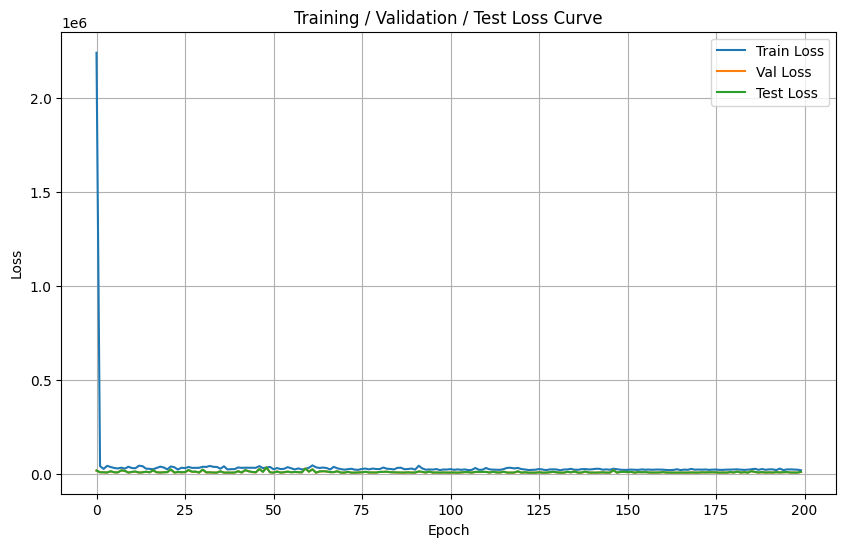

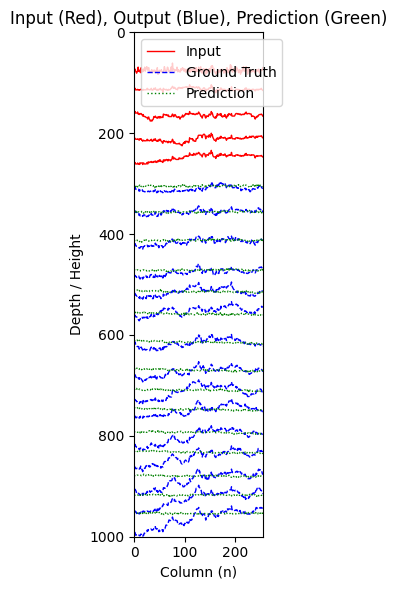

In [14]:
# @title MLP



class SimpleMLP(nn.Module):
    def __init__(self, input_dim=1280, hidden_dim=1024, output_dim=15*256):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten to (B, 1280)
        x = self.net(x)            # process
        x = x.view(x.size(0), 15, 256)  # reshape back to (B, 256, 20)
        return x




# 模型、优化器、损失
model = SimpleMLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# 训练 loop
train_losses = []
val_losses = []
test_losses = []

# 训练 loop + 验证 + 测试
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # 验证
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

    # 测试
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_test_loss += loss.item()

    # 记录 Loss
    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)
    test_losses.append(total_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Test Loss: {total_test_loss:.4f}")

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation / Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



# 获取样本
x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)




[Epoch 1] Train Loss: 20246069.2812, Val Loss: 5127834.3438, Test Loss: 5131727.9375
[Epoch 2] Train Loss: 9026969.9688, Val Loss: 964193.4961, Test Loss: 965413.4648
[Epoch 3] Train Loss: 980710.7100, Val Loss: 43807.2283, Test Loss: 43738.5344
[Epoch 4] Train Loss: 45267.1512, Val Loss: 3576.4295, Test Loss: 3605.8182
[Epoch 5] Train Loss: 7858.8490, Val Loss: 2260.6715, Test Loss: 2337.6024
[Epoch 6] Train Loss: 6693.2402, Val Loss: 2224.2023, Test Loss: 2303.8146
[Epoch 7] Train Loss: 6649.0332, Val Loss: 2221.8760, Test Loss: 2300.7326
[Epoch 8] Train Loss: 6653.5411, Val Loss: 2217.1646, Test Loss: 2297.9950
[Epoch 9] Train Loss: 6629.4351, Val Loss: 2214.4836, Test Loss: 2296.2233
[Epoch 10] Train Loss: 6614.8127, Val Loss: 2214.9731, Test Loss: 2294.6592
[Epoch 11] Train Loss: 6571.8848, Val Loss: 2212.8112, Test Loss: 2294.0490
[Epoch 12] Train Loss: 6632.5645, Val Loss: 2225.0627, Test Loss: 2300.4791
[Epoch 13] Train Loss: 6669.3293, Val Loss: 2213.2361, Test Loss: 2292.8025

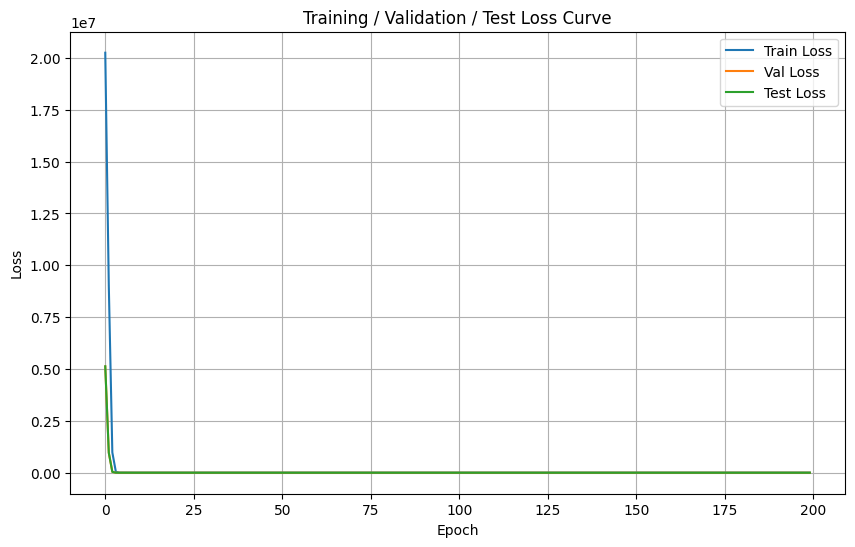

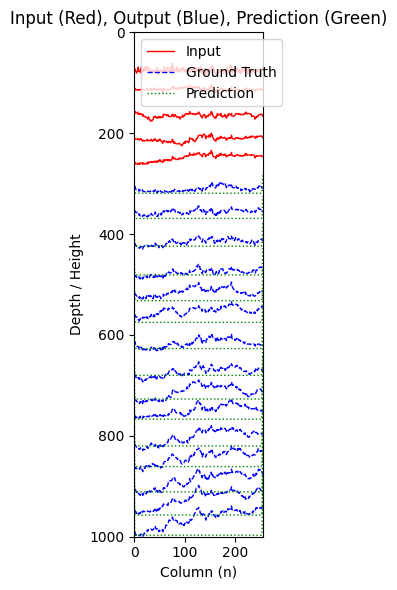

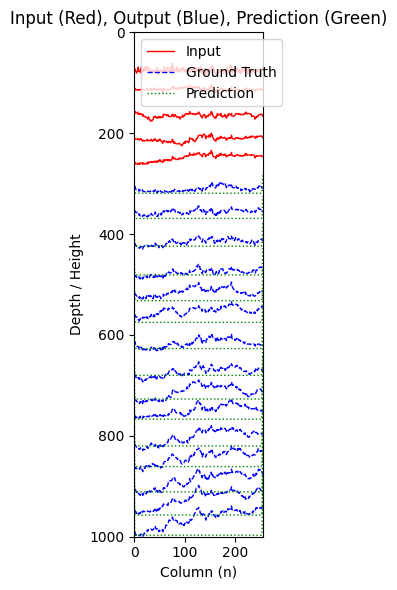

In [15]:
# @title BiLSTM(C = 5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
'''
class BiLSTM(nn.Module):
    def __init__(self, input_size=256, hidden_size=512, num_layers=2, output_seq_len=15):
        super(BiLSTM, self).__init__()
        self.output_seq_len = output_seq_len
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers,
                              batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 256)  # 双向 LSTM 输出接 Linear
        self.project_seq = nn.Linear(5, output_seq_len)  # 时间维度扩展：5 -> 15

    def forward(self, x):
        # x: (B, 5, 256)
        lstm_out, _ = self.bilstm(x)  # (B, 5, hidden*2)
        #out = self.fc(outputs)
        #print(out.shape)
        out = self.fc(lstm_out)       # (B, 5, 256)

        # 现在我们有了 (B, 5, 256)，需要变成 (B, 15, 256)
        # 方法：沿时间维度 project
        out = out.permute(0, 2, 1)         # (B, 256, 5)
        out = self.project_seq(out)        # (B, 256, 15)
        out = out.permute(0, 2, 1)         # (B, 15, 256)

        return out*1000

class BiLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, num_layers=2, output_features=15):
        super(BiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers,
                              batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.fc2 = nn.Linear(256, output_features)

    def forward(self, x):
        # x: (B, 5, 256) → 转为 (B, 256, 5)
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.bilstm(x)  # (B, 256, hidden*2)
        out = self.fc1(lstm_out)       # (B, 256, 256)
        out = F.relu(out)
        out = self.fc2(out)            # (B, 256, 15)
        out = out.permute(0, 2, 1)    # (B, 15, 256)，与 yb 对齐
        return out * 1000  # scale optional
'''


class BiLSTM(nn.Module):
    def __init__(self, input_channels=5, conv_channels=32, hidden_size=128, num_layers=2, output_features=15):
        super(BiLSTM, self).__init__()
        #self.conv1d = nn.Conv1d(input_channels, conv_channels, kernel_size=1)

        self.bilstm = nn.LSTM(input_channels, hidden_size, num_layers,
                              batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.fc2 = nn.Linear(256, output_features)

    def forward(self, x):
        # x: (B, 5, 256) → Conv1D expects (B, C, L)
        #x = self.conv1d(x)  # (B, 32, 256)
        #x = F.relu(x)

        # 转为 LSTM 输入：(B, 256, 5)
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.bilstm(x)  # (B, 256, hidden*2)
        out = self.fc1(lstm_out)       # (B, 256, 256)
        out = F.leaky_relu(out)
        out = self.fc2(out)            # (B, 256, 15)
        out = out.permute(0, 2, 1)     # (B, 15, 256)，与 yb 对齐
        return out #* 1000  # scale optional
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)





model = BiLSTM().to(DEVICE)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses = []
val_losses = []
test_losses = []

# 训练 loop + 验证 + 测试
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # 验证
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

    # 测试
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_test_loss += loss.item()

    # 记录 Loss
    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)
    test_losses.append(total_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Test Loss: {total_test_loss:.4f}")

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation / Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



# 获取样本
x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)


x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)

[Epoch 1] Train Loss: 22399432.5312, Val Loss: 7235600.0938, Test Loss: 7240353.9062
[Epoch 2] Train Loss: 21799397.8125, Val Loss: 6917718.0938, Test Loss: 6922379.5625
[Epoch 3] Train Loss: 20458215.3125, Val Loss: 6360439.3125, Test Loss: 6364906.0625
[Epoch 4] Train Loss: 18443100.8125, Val Loss: 5613043.6250, Test Loss: 5617218.5938
[Epoch 5] Train Loss: 15957437.1562, Val Loss: 4749131.2500, Test Loss: 4752930.6250
[Epoch 6] Train Loss: 13233067.2500, Val Loss: 3850732.1875, Test Loss: 3854092.5156
[Epoch 7] Train Loss: 10518848.1875, Val Loss: 2991869.2344, Test Loss: 2994753.5781
[Epoch 8] Train Loss: 8013421.2344, Val Loss: 2228227.5000, Test Loss: 2230628.3438
[Epoch 9] Train Loss: 5855945.6953, Val Loss: 1592088.7422, Test Loss: 1594023.5859
[Epoch 10] Train Loss: 4111901.6484, Val Loss: 1095419.2031, Test Loss: 1096928.3828
[Epoch 11] Train Loss: 2786421.9570, Val Loss: 729036.2148, Test Loss: 730175.8789
[Epoch 12] Train Loss: 1832022.8398, Val Loss: 472142.1504, Test Loss

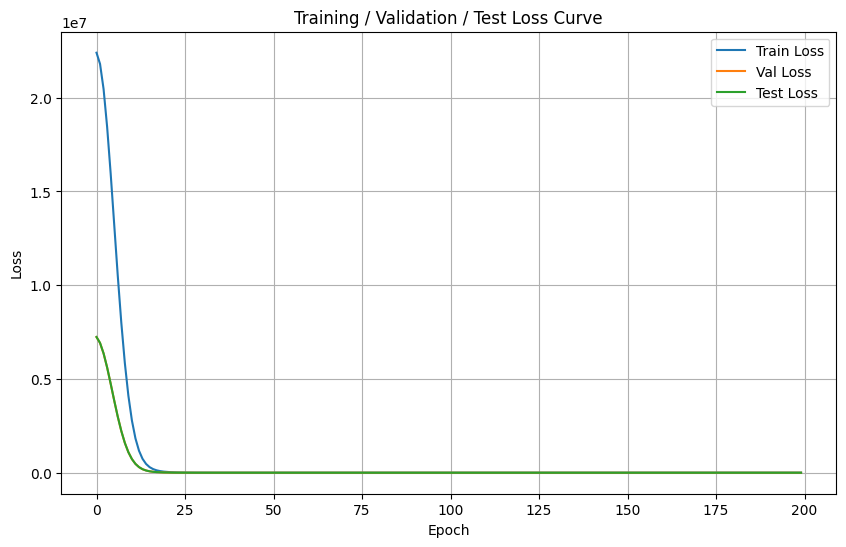

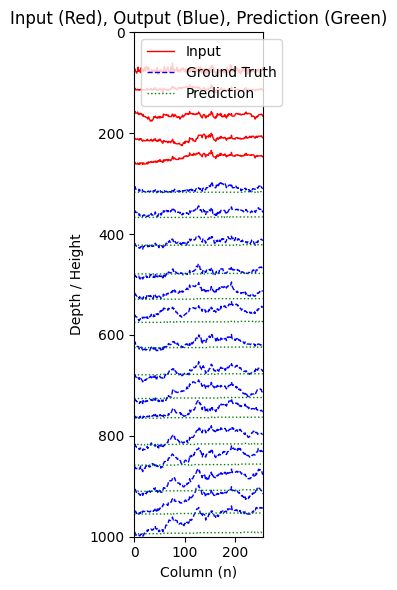

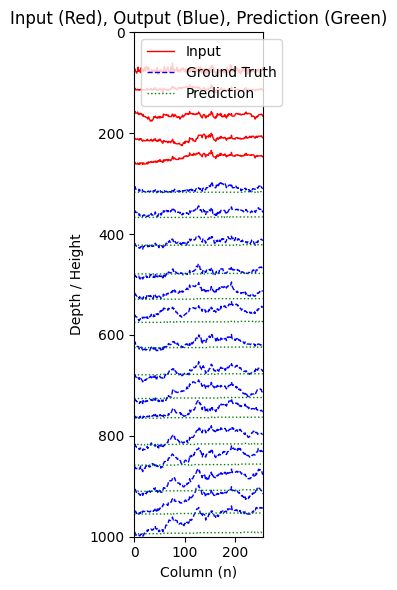

In [16]:
# @title BiLSTM(C = 256)


class BiLSTM2(nn.Module):
    def __init__(self, input_size=256, hidden_size=128, num_layers=2, output_seq_len=15):
        super(BiLSTM2, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_size * 2, 256)  # 每一步输出到 256 维
        self.expand_seq = nn.Linear(5, output_seq_len)  # 时间维扩展：5 -> 15

    def forward(self, x):
        # x: (B, 5, 256) → LSTM 期望 (B, seq_len=5, input_size=256)
        lstm_out, _ = self.bilstm(x)  # (B, 5, hidden*2)

        out = self.fc(lstm_out)  # (B, 5, 256)
        out = F.leaky_relu(out)
        # 扩展序列长度：(B, 5, 256) → (B, 15, 256)
        out = out.permute(0, 2, 1)      # (B, 256, 5)
        out = self.expand_seq(out)      # (B, 256, 15)
        out = out.permute(0, 2, 1)      # (B, 15, 256)

        return out  # 原始数据，无缩放

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)





model = BiLSTM2().to(DEVICE)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses = []
val_losses = []
test_losses = []

# 训练 loop + 验证 + 测试
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # 验证
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

    # 测试
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_test_loss += loss.item()

    # 记录 Loss
    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)
    test_losses.append(total_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Test Loss: {total_test_loss:.4f}")

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation / Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



# 获取样本
x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)


x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)

[Epoch 1] Train Loss: 22246169.9062, Val Loss: 7176627.3438, Test Loss: 7181335.4375
[Epoch 2] Train Loss: 21783375.3438, Val Loss: 7001825.8438, Test Loss: 7006465.7188
[Epoch 3] Train Loss: 21183831.2188, Val Loss: 6786034.7500, Test Loss: 6790588.6250
[Epoch 4] Train Loss: 20462622.7500, Val Loss: 6532549.6562, Test Loss: 6536999.7188
[Epoch 5] Train Loss: 19632070.0000, Val Loss: 6244286.7812, Test Loss: 6248618.5625
[Epoch 6] Train Loss: 18698958.8125, Val Loss: 5925181.7188, Test Loss: 5929378.5938
[Epoch 7] Train Loss: 17680492.0000, Val Loss: 5580062.4375, Test Loss: 5584109.9062
[Epoch 8] Train Loss: 16585675.9375, Val Loss: 5213885.6250, Test Loss: 5217767.6250
[Epoch 9] Train Loss: 15443328.6562, Val Loss: 4833793.2812, Test Loss: 4837496.3438
[Epoch 10] Train Loss: 14259781.6250, Val Loss: 4444031.0000, Test Loss: 4447545.8125
[Epoch 11] Train Loss: 13061733.3125, Val Loss: 4052553.0000, Test Loss: 4055869.4062
[Epoch 12] Train Loss: 11862621.8281, Val Loss: 3665042.4844, T

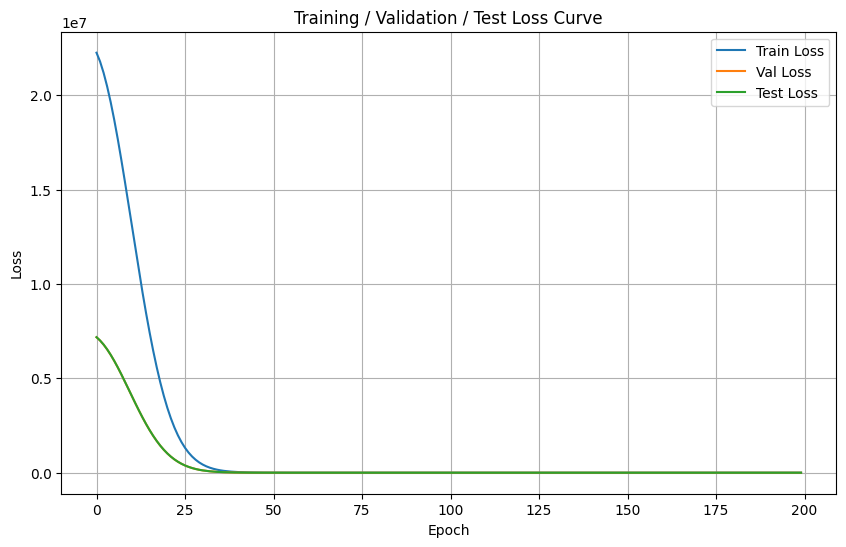

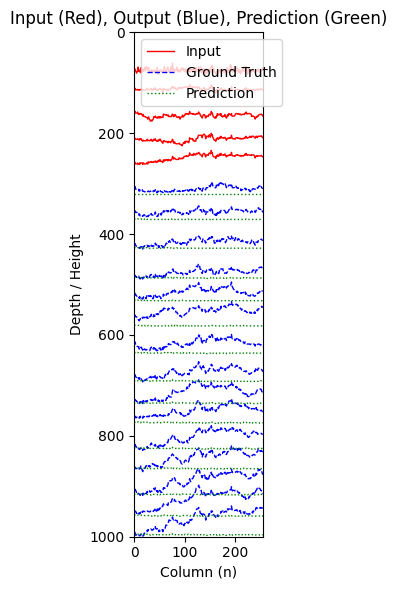

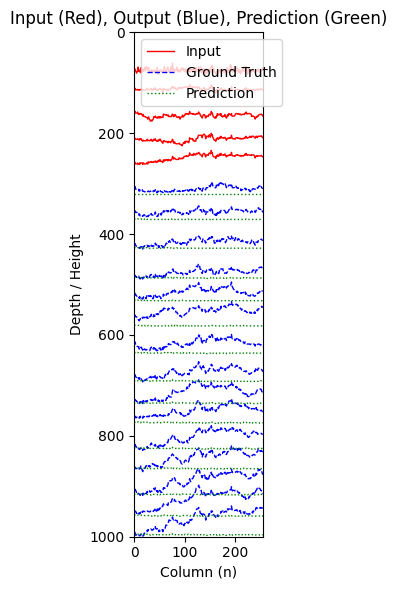

In [17]:
# @title transformer(C = 5)


class TransformerModel(nn.Module):
    def __init__(self, input_dim=5, model_dim=128, num_heads=4, num_layers=2, output_dim=15):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, x):
        # x: (B, 5, 256) → 转为 (B, 256, 5)
        x = x.permute(0, 2, 1)  # (B, 256, 5)
        x = self.input_proj(x)  # (B, 256, model_dim)

        x = self.transformer_encoder(x)  # (B, 256, model_dim)

        out = self.fc(x)  # (B, 256, 15)

        out = out.permute(0, 2, 1)  # (B, 15, 256)

        return out

model = TransformerModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.MSELoss()

train_losses = []
val_losses = []
test_losses = []

# 训练 loop + 验证 + 测试
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # 验证
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

    # 测试
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_test_loss += loss.item()

    # 记录 Loss
    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)
    test_losses.append(total_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Test Loss: {total_test_loss:.4f}")

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation / Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



# 获取样本
x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)


x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)

[Epoch 1] Train Loss: 22022919.4375, Val Loss: 6676288.5625, Test Loss: 6680808.8438
[Epoch 2] Train Loss: 14515431.5000, Val Loss: 1953574.2891, Test Loss: 1955514.9375
[Epoch 3] Train Loss: 2131261.7852, Val Loss: 244405.7090, Test Loss: 244442.0000
[Epoch 4] Train Loss: 652367.6104, Val Loss: 201012.9834, Test Loss: 201236.0723
[Epoch 5] Train Loss: 612099.8477, Val Loss: 198433.1494, Test Loss: 198685.4580
[Epoch 6] Train Loss: 608003.1943, Val Loss: 197806.9102, Test Loss: 198066.2959
[Epoch 7] Train Loss: 606469.1963, Val Loss: 197465.8096, Test Loss: 197715.4189
[Epoch 8] Train Loss: 604601.4053, Val Loss: 196864.6582, Test Loss: 197120.6094
[Epoch 9] Train Loss: 602342.6982, Val Loss: 196723.9180, Test Loss: 196957.4111
[Epoch 10] Train Loss: 600169.8467, Val Loss: 194743.0137, Test Loss: 195019.6113
[Epoch 11] Train Loss: 596324.5059, Val Loss: 194336.1963, Test Loss: 194570.1758
[Epoch 12] Train Loss: 592039.1797, Val Loss: 192768.3945, Test Loss: 193015.0645
[Epoch 13] Train

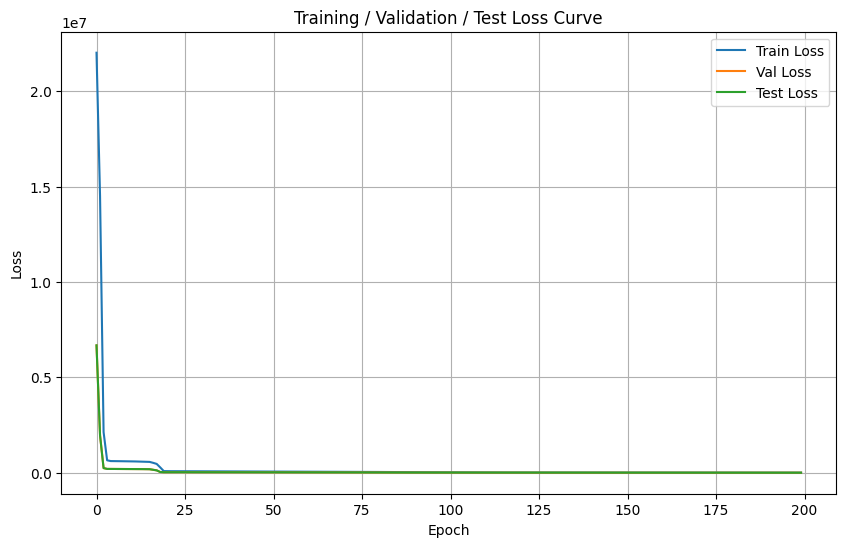

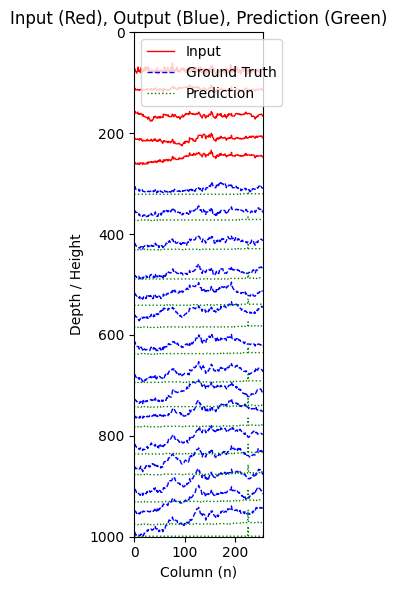

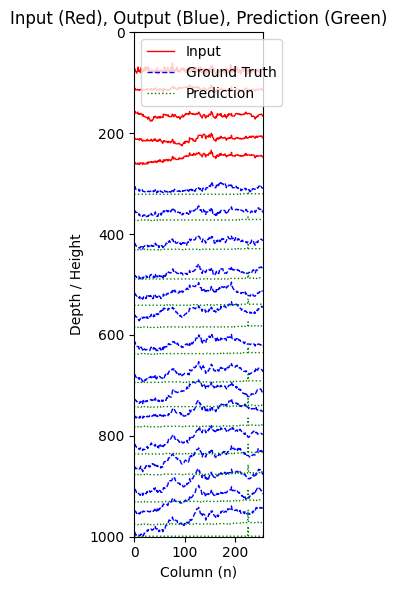

In [18]:
# @title transformer(C = 256)
class TransformerModel2(nn.Module):
    def __init__(self, input_dim=256, model_dim=128, num_heads=4, num_layers=2, output_seq_len=15):
        super(TransformerModel2, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(model_dim, input_dim)  # 回到原 256 维
        self.fc2 = nn.Linear(5, 256)
        self.expand_seq = nn.Linear(256, output_seq_len)  # 扩展序列 5 -> 15

    def forward(self, x):
        # x: (B, 5, 256) → 转为 (B, 5, 256)
        # Transformer 期望 (B, seq_len, feature_dim)，我们直接使用

        x = self.input_proj(x)  # (B, 5, model_dim)

        x = self.transformer_encoder(x)  # (B, 5, model_dim)

        out = self.fc(x)  # (B, 5, 256)

        # 扩展时间维：5 -> 15
        out = out.permute(0, 2, 1)      # (B, 256, 5)
        out = F.relu(out)
        out = self.fc2(out)             # (B, 256, 256)
        out = F.relu(out)
        out = self.expand_seq(out)      # (B, 256, 15)
        out = out.permute(0, 2, 1)      # (B, 15, 256)

        return out


model = TransformerModel2().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.MSELoss()

train_losses = []
val_losses = []
test_losses = []

# 训练 loop + 验证 + 测试
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # 验证
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

    # 测试
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_test_loss += loss.item()

    # 记录 Loss
    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)
    test_losses.append(total_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Test Loss: {total_test_loss:.4f}")

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation / Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



# 获取样本
x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)


x_sample, y_sample = dataset[0]  # x: (5, 256), y: (15, 256)
x_sample_tensor = x_sample.unsqueeze(0).to(DEVICE)  # add batch dim

# 模型预测
model.eval()
with torch.no_grad():
    pred_sample = model(x_sample_tensor)  # (1, 15, 256)
    pred_sample = pred_sample.squeeze(0).cpu().numpy()

# 转 int for plotting
x_sample_np = x_sample.numpy().astype(int)
y_sample_np = y_sample.numpy().astype(int)
pred_sample_np = np.clip(pred_sample, 0, 999).astype(int)  # clip to canvas height

# 绘图
plot_layer_on_canvas(x_sample_np, y_sample_np, pred_sample_np)

# Fusion

In [20]:
# @title Dataset
import scipy
'''
class FusionDataset1(Dataset):
    def __init__(self, data, mask, layer_x, H):
        """
        data: numpy array (N, 1, H, W)
        mask: numpy array (N, 1, H, W)
        layer_x: numpy array (N, 5, W)
        H: height of the image
        """
        self.data = torch.from_numpy(data).float()
        self.mask = torch.from_numpy(mask).long()
        self.layer_x = torch.from_numpy(layer_x).float()
        self.H = H

    def __len__(self):
        return self.data.shape[0]

    def layer_coords_to_mask(self, layer_coords):
        # layer_coords: (5, W)
        num_layers, W = layer_coords.shape
        layer_mask = torch.zeros((num_layers, self.H, W), dtype=torch.float32)

        for l in range(num_layers):
            for w in range(W):
                h_idx = int(layer_coords[l, w].item())
                h_idx = max(0, min(self.H - 1, h_idx))
                layer_mask[l, h_idx, w] = 1.0

        return layer_mask

    def __getitem__(self, idx):
        img = self.data[idx]     # (1, H, W)
        mask = self.mask[idx]    # (1, H, W)
        layer_coords = self.layer_x[idx]  # (5, W)

        # Convert to mask (5, H, W)
        layer_mask = self.layer_coords_to_mask(layer_coords)
        #layer_mask = smooth_layer_mask(layer_mask, sigma=2)  # (B, 5, H, W)
        # Fuse
        fused_input = torch.cat([img, layer_mask], dim=0)  # (6, H, W)

        return fused_input, mask
'''
def gaussian_kernel(size=5, sigma=2):
    coords = torch.arange(size, dtype=torch.float32) - size // 2
    g = torch.exp(-coords**2 / (2 * sigma**2))
    g = g / g.sum()
    kernel = g[:, None] * g[None, :]
    return kernel

def smooth_layer_mask_gpu(mask, sigma=2):
    # mask: (5, H, W) -> (1, 5, H, W)
    mask = mask.unsqueeze(0)
    size = int(2 * sigma + 1)
    kernel = gaussian_kernel(size=size, sigma=sigma).to(mask.device)
    kernel = kernel.expand(mask.shape[1], 1, size, size)  # (C, 1, kH, kW)
    smoothed = F.conv2d(mask, kernel, padding=size//2, groups=mask.shape[1])
    return smoothed.squeeze(0)  # (5, H, W)

def layer_coords_to_mask(layer_coords, H):
    # layer_coords: (5, W)
    num_layers, W = layer_coords.shape
    layer_mask = torch.zeros((num_layers, H, W), dtype=torch.float32)

    for l in range(num_layers):
        for w in range(W):
            h_idx = int(layer_coords[l, w].item())
            h_idx = max(0, min(H - 1, h_idx))
            layer_mask[l, h_idx, w] = 1.0

    return layer_mask  # (5, H, W)
# layer_x: numpy array (N, 5, W)
# H: image height

all_smoothed_masks = []
H = data.shape[2]  # 高度从原图像 shape 获取

for i in range(len(layer_x)):
    raw_coords = torch.tensor(layer_x[i])  # (5, W)
    raw_mask = layer_coords_to_mask(raw_coords, H)  # (5, H, W)
    smoothed = smooth_layer_mask_gpu(raw_mask, sigma=2)  # (5, H, W)
    all_smoothed_masks.append(smoothed.unsqueeze(0))  # (1, 5, H, W)

# 拼接成 (N, 5, H, W)
smoothed_layer_masks = torch.cat(all_smoothed_masks, dim=0)
from torch.utils.data import Dataset

class FusionDatasetCached(Dataset):
    def __init__(self, data, mask, smoothed_layer_masks):
        self.data = torch.from_numpy(data).float()  # (N, 1, H, W)
        self.mask = torch.from_numpy(mask).long()   # (N, 1, H, W)
        self.smoothed_layer_masks = smoothed_layer_masks  # (N, 5, H, W)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img = self.data[idx]              # (1, H, W)
        mask = self.mask[idx]             # (1, H, W)
        layer_mask = self.smoothed_layer_masks[idx]  # (5, H, W)

        fused_input = torch.cat([img, layer_mask], dim=0)  # (6, H, W)

        return fused_input, mask


N = data.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

train_size = int(0.6 * N)
val_size = int(0.2 * N)
test_size = N - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

#dataset = FusionDataset1(data, mask, layer_x, H=1000)
dataset = FusionDatasetCached(data, mask, smoothed_layer_masks)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)

[Epoch 1/200] Train Loss: 2.8837, Val Loss: 2.5577，Test Loss: 2.5532, miou:0.0811,pa:0.1936,mpa:0.1719
[Epoch 1] New best model saved (Val Loss: 2.5577)
[Epoch 2/200] Train Loss: 2.2677, Val Loss: 2.1028，Test Loss: 2.0938, miou:0.1218,pa:0.2323,mpa:0.2197
[Epoch 2] New best model saved (Val Loss: 2.1028)
[Epoch 3/200] Train Loss: 2.0459, Val Loss: 2.0233，Test Loss: 2.0176, miou:0.1473,pa:0.2613,mpa:0.2489
[Epoch 3] New best model saved (Val Loss: 2.0233)
[Epoch 4/200] Train Loss: 1.9375, Val Loss: 1.8894，Test Loss: 1.8795, miou:0.1912,pa:0.3172,mpa:0.2998
[Epoch 4] New best model saved (Val Loss: 1.8894)
[Epoch 5/200] Train Loss: 1.8424, Val Loss: 1.8224，Test Loss: 1.8102, miou:0.2317,pa:0.3491,mpa:0.3389
[Epoch 5] New best model saved (Val Loss: 1.8224)
[Epoch 6/200] Train Loss: 1.7574, Val Loss: 1.7150，Test Loss: 1.7046, miou:0.2758,pa:0.3856,mpa:0.3851
[Epoch 6] New best model saved (Val Loss: 1.7150)
[Epoch 7/200] Train Loss: 1.6782, Val Loss: 1.6726，Test Loss: 1.6605, miou:0.2841,

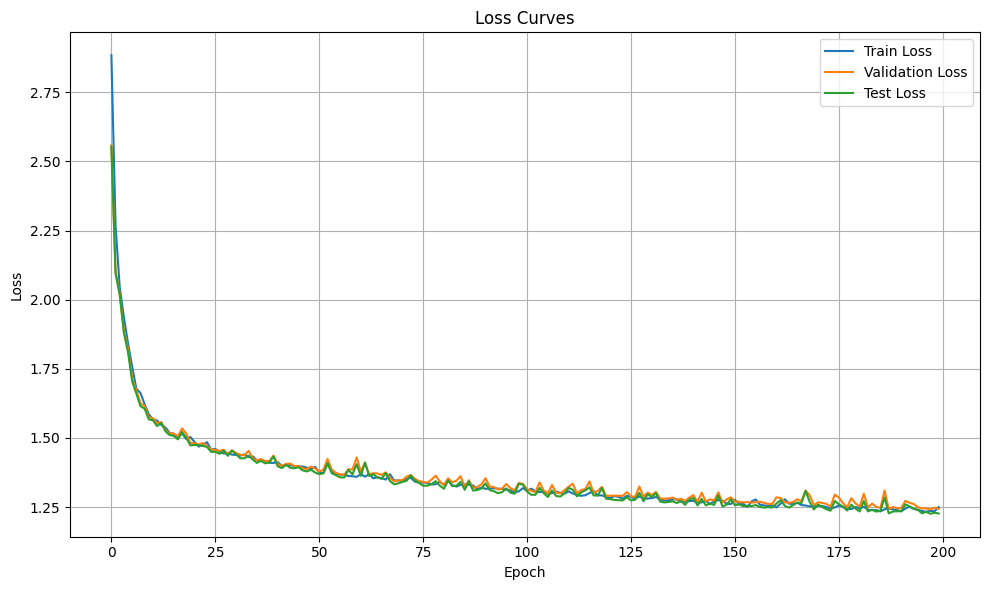

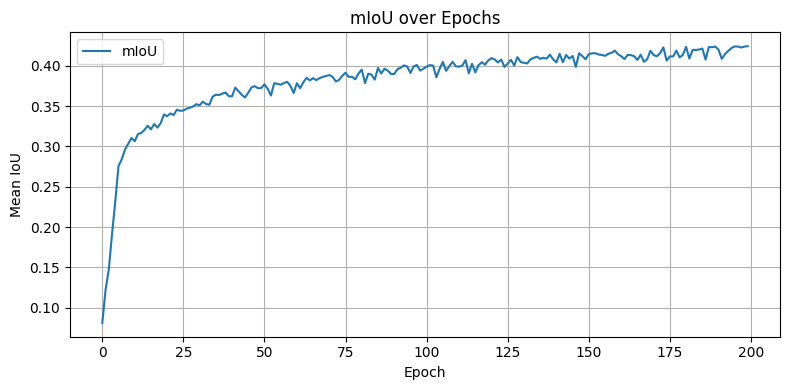

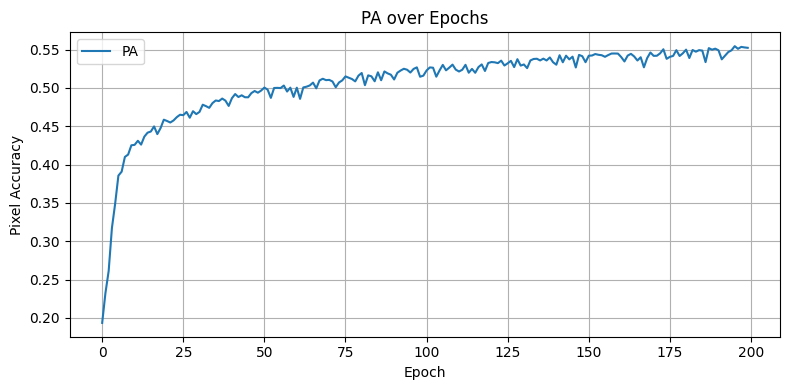

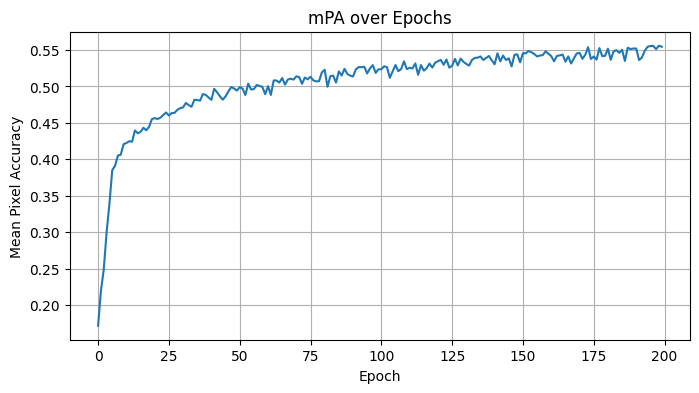

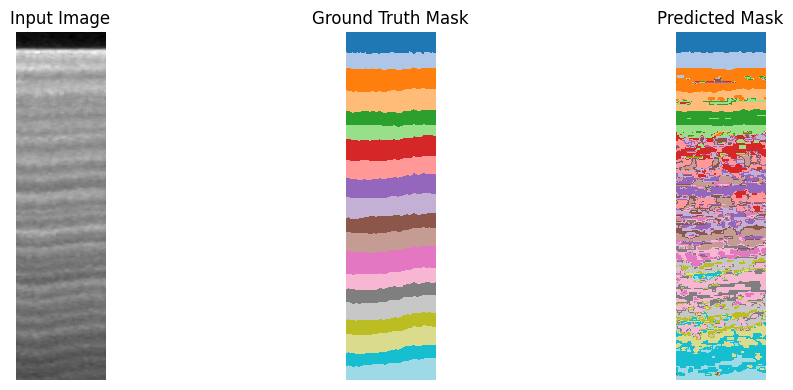

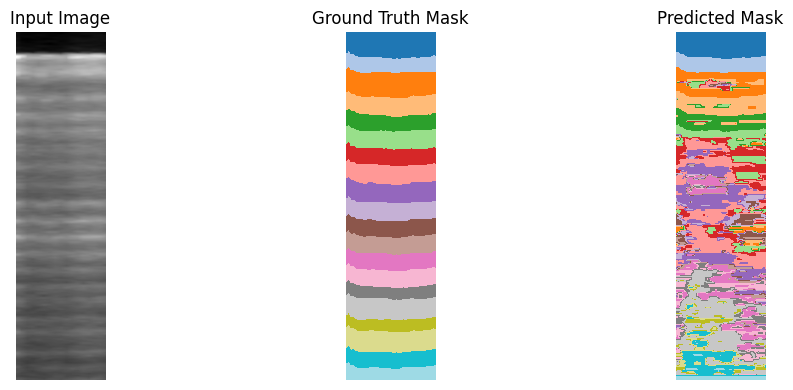

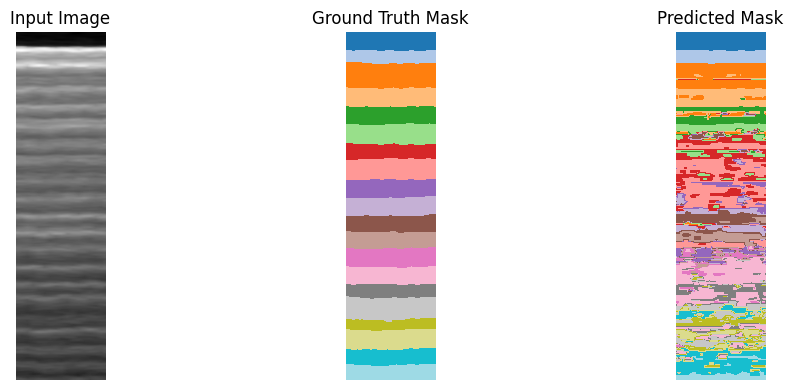

In [21]:
# @title Early, Dataset, concat, cnn


class SimpleSegNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

        )
        self.decoder = nn.Sequential(

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, num_classes, 1)  # logits for all classes
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


model = SimpleSegNet(NUM_CLASSES).to(DEVICE)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        #print(pred.shape,yb.shape)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            #print(f"PA: {pa:.4f}, mPA: {mpa:.4f}")
            pa_total += pa
            mpa_total += mpa
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")

plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_sample(model, test_loader, DEVICE, num_classes=NUM_CLASSES, max_samples=3)

del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 1.0718, Val Loss: 2.6616，Test Loss: 2.6464, miou:0.1459,pa:0.2733,mpa:0.2529
[Epoch 1] New best model saved (Val Loss: 2.6616)
[Epoch 2/200] Train Loss: 0.3161, Val Loss: 0.2933，Test Loss: 0.2864, miou:0.7990,pa:0.9055,mpa:0.8756
[Epoch 2] New best model saved (Val Loss: 0.2933)
[Epoch 3/200] Train Loss: 0.2225, Val Loss: 0.2322，Test Loss: 0.2280, miou:0.8108,pa:0.9113,mpa:0.8840
[Epoch 3] New best model saved (Val Loss: 0.2322)
[Epoch 4/200] Train Loss: 0.1918, Val Loss: 0.1951，Test Loss: 0.1940, miou:0.8387,pa:0.9238,mpa:0.9043
[Epoch 4] New best model saved (Val Loss: 0.1951)
[Epoch 5/200] Train Loss: 0.1712, Val Loss: 0.1878，Test Loss: 0.1872, miou:0.8430,pa:0.9252,mpa:0.9087
[Epoch 5] New best model saved (Val Loss: 0.1878)
[Epoch 6/200] Train Loss: 0.1632, Val Loss: 0.1756，Test Loss: 0.1753, miou:0.8496,pa:0.9288,mpa:0.9163
[Epoch 6] New best model saved (Val Loss: 0.1756)
[Epoch 7/200] Train Loss: 0.1497, Val Loss: 0.1592，Test Loss: 0.1590, miou:0.8627,

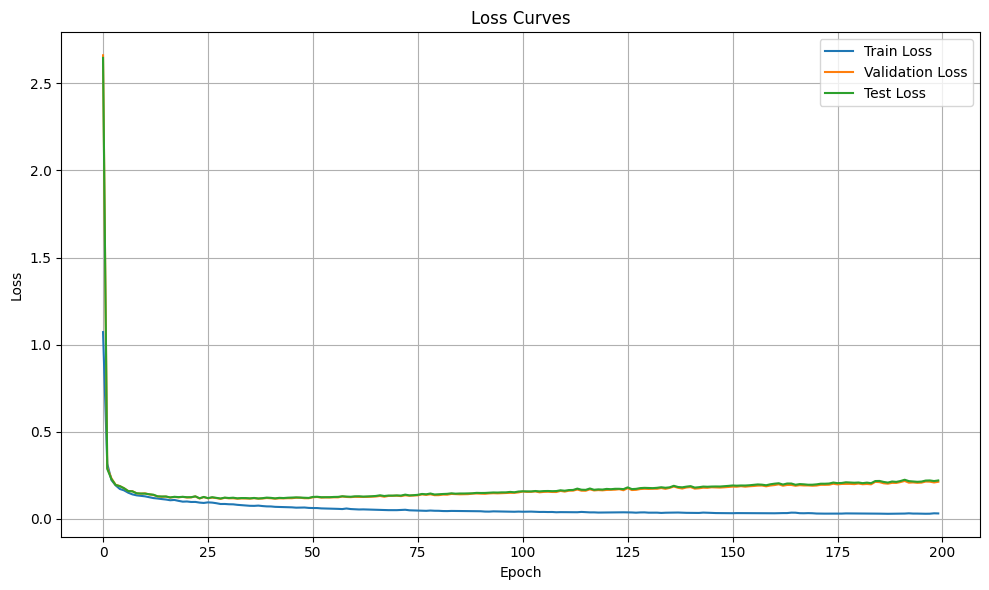

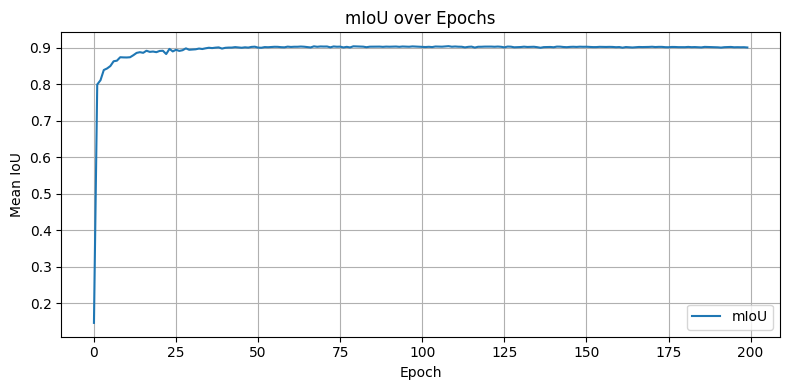

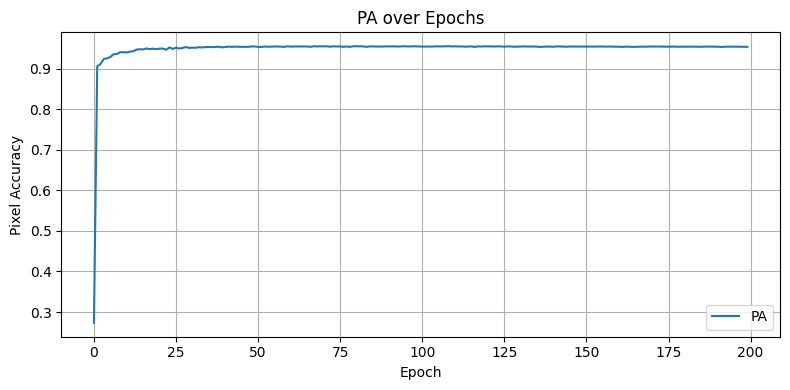

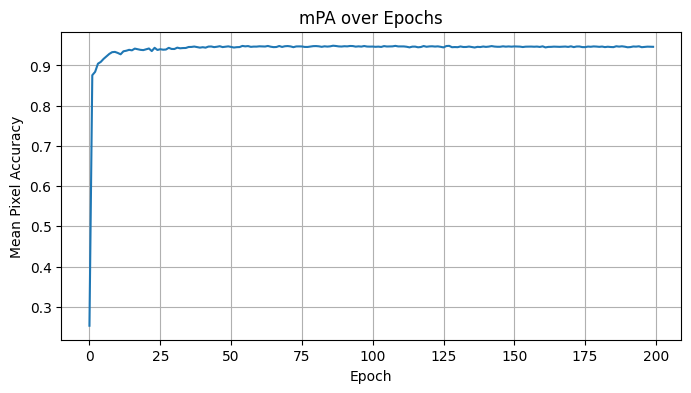

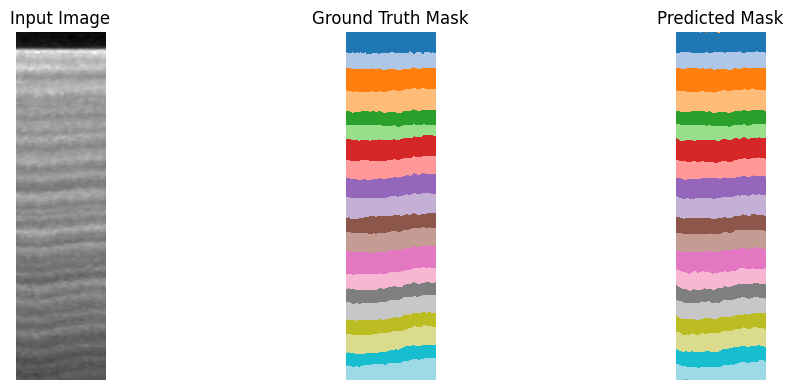

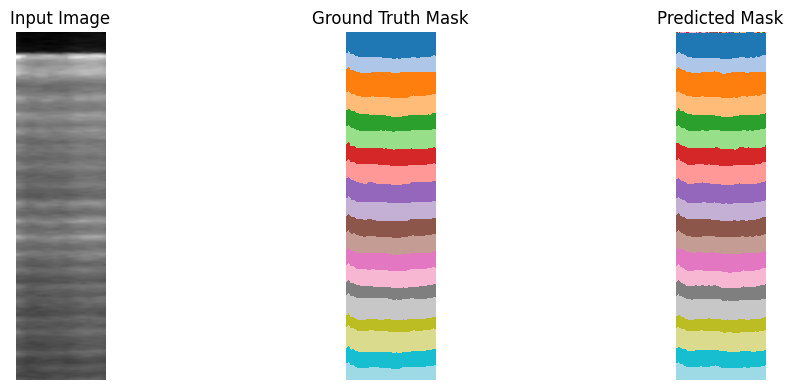

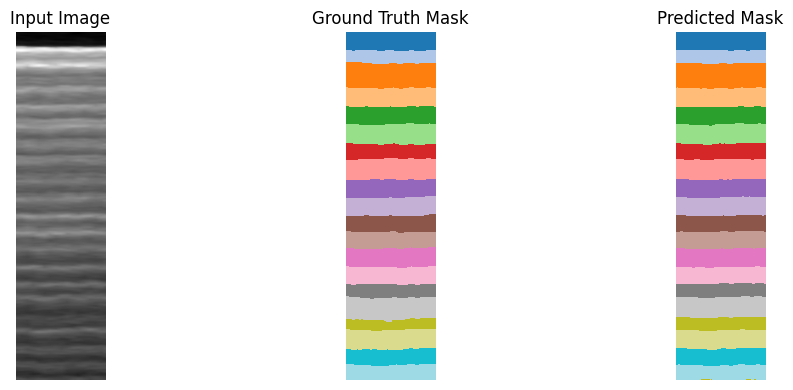

In [22]:
# @title Early, Dataset, concat, fno



class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.bn = nn.BatchNorm2d(out_channels)
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #print('x',x.shape)
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.fft.rfft(x, 2, normalized=True, onesided=True)#old version
        x_ft = torch.fft.rfft2(x)#new version

        # Multiply relevant Fourier modes
        #print('x_ft',x_ft.shape)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))#old version
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))#new version
        x = self.bn(x)
        return x

class SimpleFNOBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, width):
        super(SimpleFNOBlock2d, self).__init__()
        self.width = width
        self.in_proj = nn.Conv2d(in_channels, width, 1)  # Lift to width channels

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        #self.conv3 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        #self.w3 = nn.Conv2d(width, width, 1)

        self.out_proj = nn.Conv2d(width, out_channels, 1)  # Back to 1 channel for regression

    def forward(self, x):
        x = self.in_proj(x)  # (B, width, H, W)

        x1 = self.conv0(x) + self.w0(x)
        x = F.relu(x1)

        x1 = self.conv1(x) + self.w1(x)
        x = F.relu(x1)

        x1 = self.conv2(x) + self.w2(x)
        x = F.relu(x1)

        #x1 = self.conv3(x) + self.w3(x)
        #x = F.relu(x1)

        out = self.out_proj(x)  # (B, 1, H, W)
        return out#.squeeze(1)  # (B, 1, H, W) → (B, H, W)


model = SimpleFNOBlock2d(in_channels=6, out_channels=NUM_CLASSES, modes1=16, modes2=16, width=32).to(DEVICE)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        #print(pred.shape,yb.shape)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            #print(f"PA: {pa:.4f}, mPA: {mpa:.4f}")
            pa_total += pa
            mpa_total += mpa
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")

plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_sample(model, test_loader, DEVICE, num_classes=NUM_CLASSES, max_samples=3)

del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 2.8301, Val Loss: 2.5549，Test Loss: 2.5537, miou:0.0408,pa:0.1484,mpa:0.1408
[Epoch 1] New best model saved (Val Loss: 2.5549)
[Epoch 2/200] Train Loss: 2.3930, Val Loss: 2.2470，Test Loss: 2.2387, miou:0.1381,pa:0.2462,mpa:0.2404
[Epoch 2] New best model saved (Val Loss: 2.2470)
[Epoch 3/200] Train Loss: 2.1160, Val Loss: 2.0294，Test Loss: 2.0154, miou:0.1545,pa:0.2725,mpa:0.2649
[Epoch 3] New best model saved (Val Loss: 2.0294)
[Epoch 4/200] Train Loss: 1.9883, Val Loss: 1.9290，Test Loss: 1.9141, miou:0.1836,pa:0.2929,mpa:0.2888
[Epoch 4] New best model saved (Val Loss: 1.9290)
[Epoch 5/200] Train Loss: 1.9151, Val Loss: 1.8764，Test Loss: 1.8625, miou:0.1959,pa:0.3055,mpa:0.3076
[Epoch 5] New best model saved (Val Loss: 1.8764)
[Epoch 6/200] Train Loss: 1.8649, Val Loss: 1.8323，Test Loss: 1.8139, miou:0.2081,pa:0.3189,mpa:0.3237
[Epoch 6] New best model saved (Val Loss: 1.8323)
[Epoch 7/200] Train Loss: 1.8370, Val Loss: 1.8104，Test Loss: 1.7923, miou:0.2117,

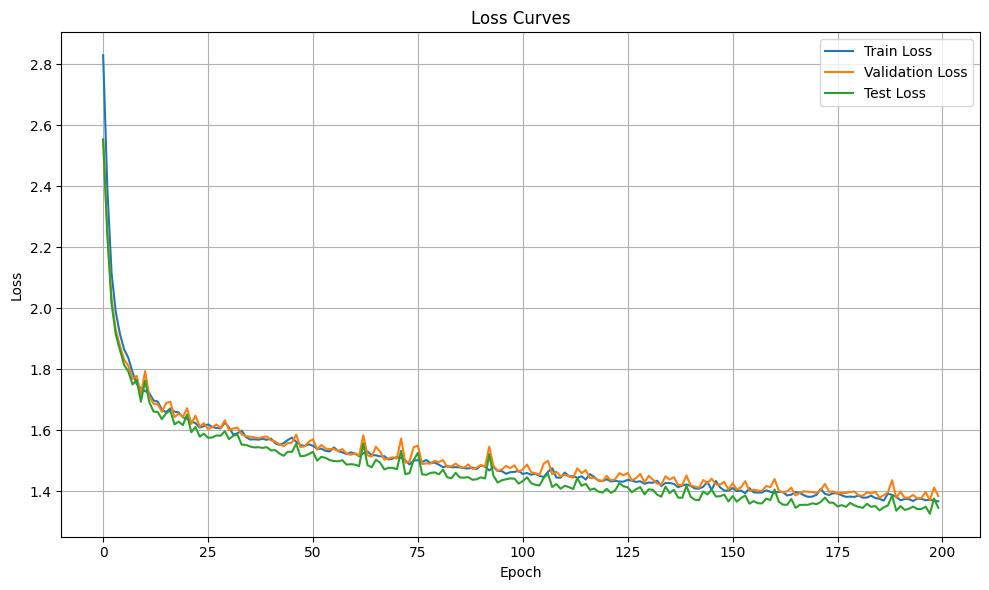

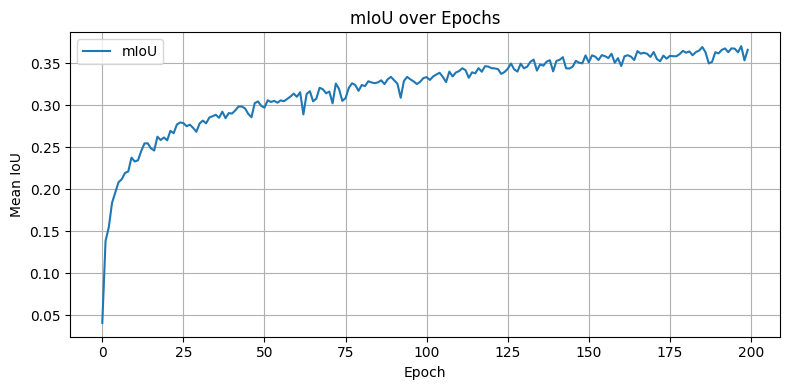

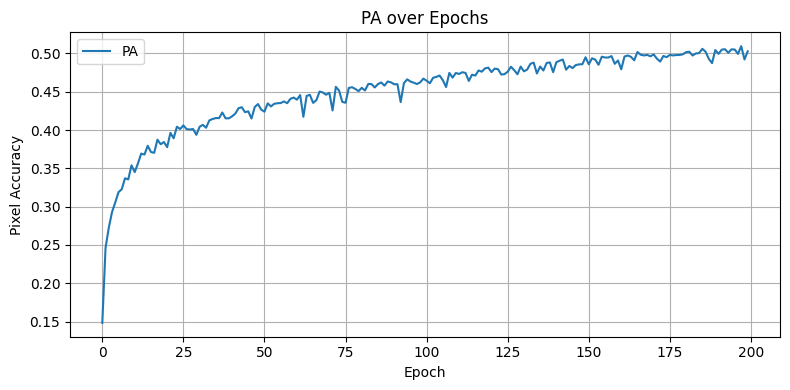

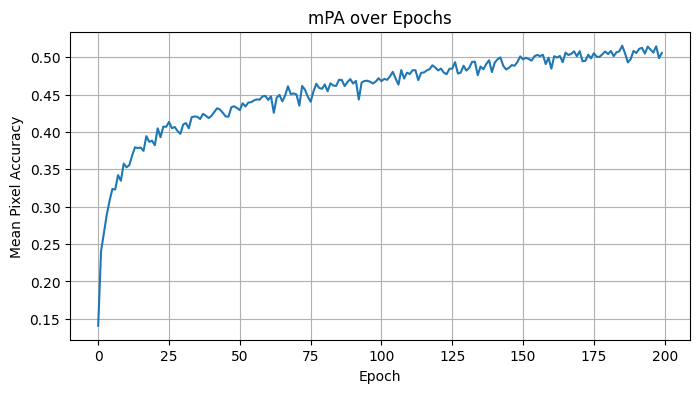

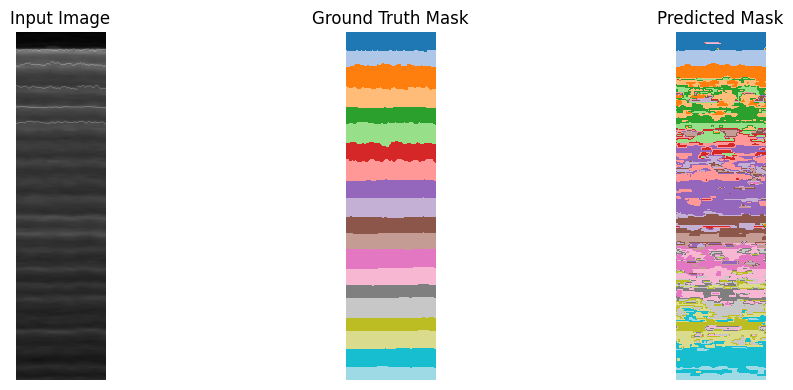

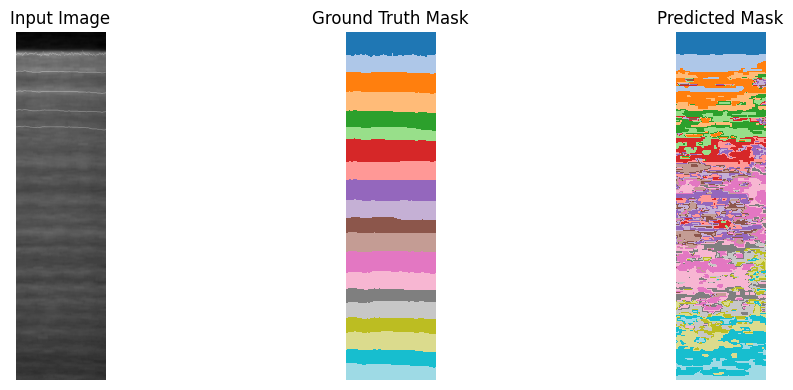

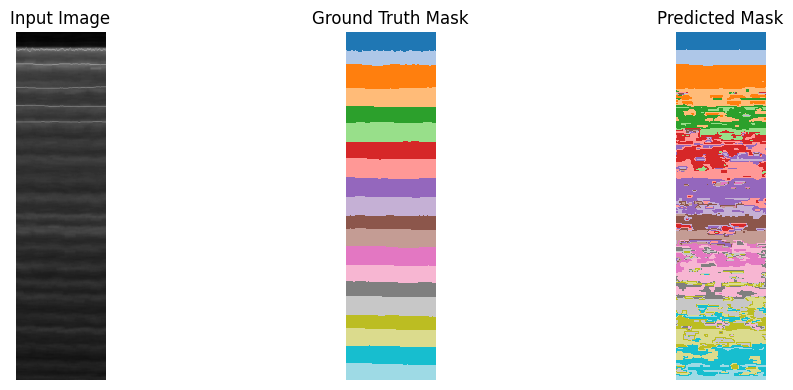

In [23]:
# @title Early, Dataset，add, cnn

import scipy

class FusionDataset1(Dataset):
    def __init__(self, data, mask, layer_x, H):
        """
        data: numpy array (N, 1, H, W)
        mask: numpy array (N, 1, H, W)
        layer_x: numpy array (N, 5, W)
        H: height of the image
        """
        self.data = torch.from_numpy(data).float()
        self.mask = torch.from_numpy(mask).long()
        self.layer_x = torch.from_numpy(layer_x).float()
        self.H = H

    def __len__(self):
        return self.data.shape[0]

    def layer_coords_to_mask(self, layer_coords):
        # layer_coords: (5, W)
        num_layers, W = layer_coords.shape
        layer_mask = torch.zeros((num_layers, self.H, W), dtype=torch.float32)

        for l in range(num_layers):
            for w in range(W):
                h_idx = int(layer_coords[l, w].item())
                h_idx = max(0, min(self.H - 1, h_idx))
                layer_mask[l, h_idx, w] = 1.0

        return layer_mask

    def __getitem__(self, idx):
        img = self.data[idx]     # (1, H, W)
        mask = self.mask[idx]    # (1, H, W)
        layer_coords = self.layer_x[idx]  # (5, W)

        # Convert to mask (5, H, W)
        layer_mask = self.layer_coords_to_mask(layer_coords)
        #layer_mask = smooth_layer_mask(layer_mask, sigma=2)  # (B, 5, H, W)
        # Fuse
        fused_input = torch.cat([img, layer_mask], dim=0)  # (6, H, W)
        fused_input = fused_input.sum(dim=0, keepdim=True)  # (1, H, W)

        return fused_input, mask




N = data.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

train_size = int(0.6 * N)
val_size = int(0.2 * N)
test_size = N - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

dataset = FusionDataset1(data, mask, layer_x, H=1000)
#dataset = FusionDatasetCached(data, mask, smoothed_layer_masks)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)



class SimpleSegNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),

        )
        self.decoder = nn.Sequential(

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, num_classes, 1)  # logits for all classes
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


model = SimpleSegNet(NUM_CLASSES).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        #print(pred.shape,yb.shape)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            #print(f"PA: {pa:.4f}, mPA: {mpa:.4f}")
            pa_total += pa
            mpa_total += mpa
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")

plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_sample(model, test_loader, DEVICE, num_classes=NUM_CLASSES, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 1.2290, Val Loss: 1.7982，Test Loss: 1.7842, miou:0.6762,pa:0.8264,mpa:0.7926
[Epoch 1] New best model saved (Val Loss: 1.7982)
[Epoch 2/200] Train Loss: 0.3607, Val Loss: 0.2959，Test Loss: 0.2709, miou:0.7953,pa:0.9007,mpa:0.8750
[Epoch 2] New best model saved (Val Loss: 0.2959)
[Epoch 3/200] Train Loss: 0.2483, Val Loss: 0.2513，Test Loss: 0.2322, miou:0.8186,pa:0.9100,mpa:0.8983
[Epoch 3] New best model saved (Val Loss: 0.2513)
[Epoch 4/200] Train Loss: 0.2201, Val Loss: 0.2139，Test Loss: 0.1994, miou:0.8403,pa:0.9226,mpa:0.9103
[Epoch 4] New best model saved (Val Loss: 0.2139)
[Epoch 5/200] Train Loss: 0.1982, Val Loss: 0.2072，Test Loss: 0.1927, miou:0.8443,pa:0.9237,mpa:0.9168
[Epoch 5] New best model saved (Val Loss: 0.2072)
[Epoch 6/200] Train Loss: 0.1857, Val Loss: 0.1928，Test Loss: 0.1817, miou:0.8478,pa:0.9264,mpa:0.9142
[Epoch 6] New best model saved (Val Loss: 0.1928)
[Epoch 7/200] Train Loss: 0.1727, Val Loss: 0.1819，Test Loss: 0.1677, miou:0.8553,

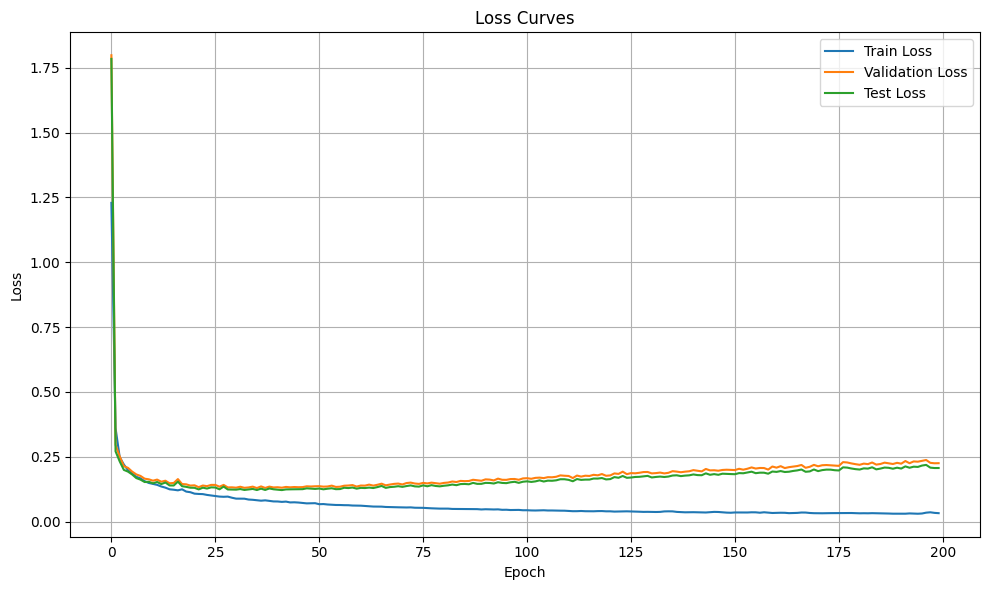

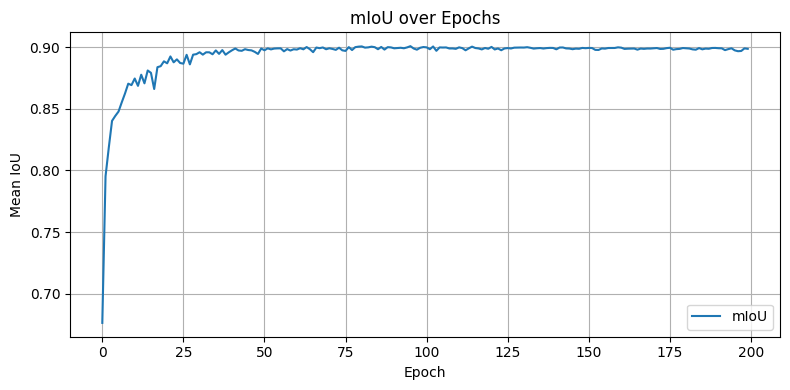

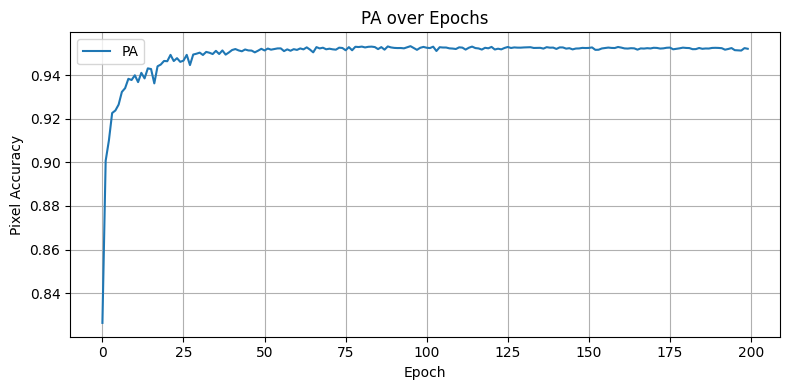

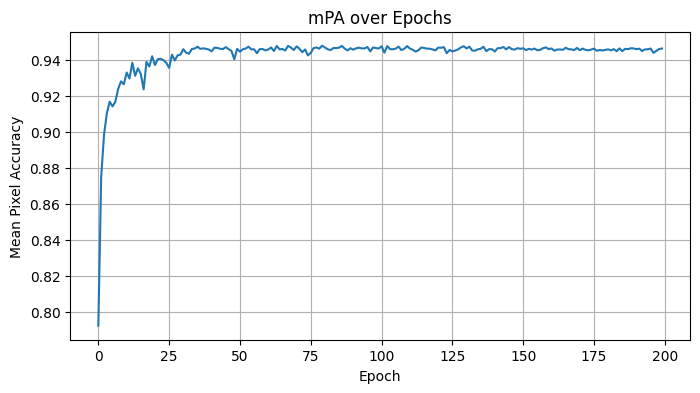

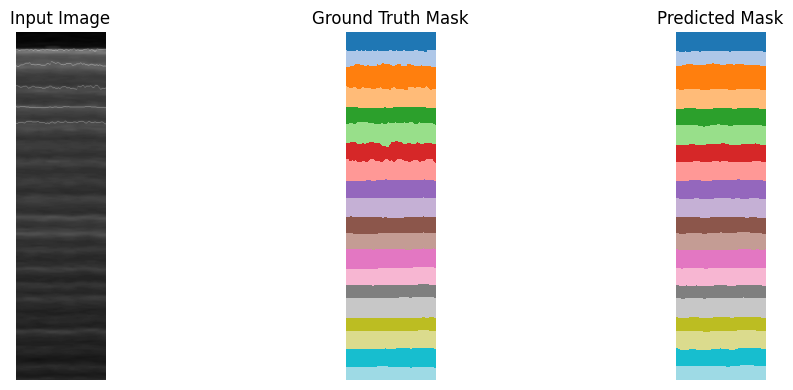

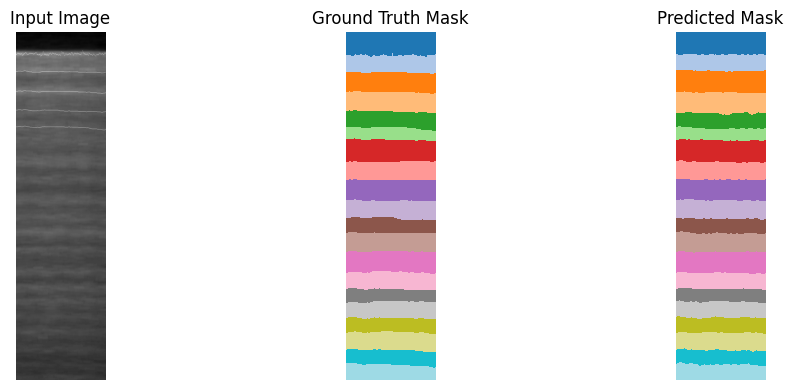

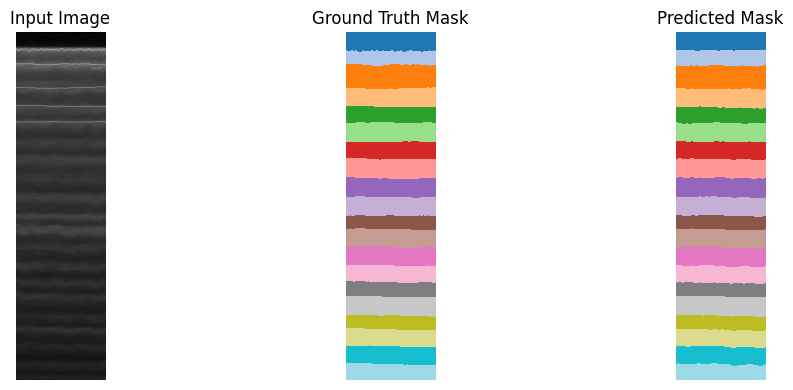

In [24]:
# @title Early, Dataset，add, fno


class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.bn = nn.BatchNorm2d(out_channels)
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #print('x',x.shape)
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.fft.rfft(x, 2, normalized=True, onesided=True)#old version
        x_ft = torch.fft.rfft2(x)#new version

        # Multiply relevant Fourier modes
        #print('x_ft',x_ft.shape)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))#old version
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))#new version
        x = self.bn(x)
        return x

class SimpleFNOBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, width):
        super(SimpleFNOBlock2d, self).__init__()
        self.width = width
        self.in_proj = nn.Conv2d(in_channels, width, 1)  # Lift to width channels

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        #self.conv3 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        #self.w3 = nn.Conv2d(width, width, 1)

        self.out_proj = nn.Conv2d(width, out_channels, 1)  # Back to 1 channel for regression

    def forward(self, x):
        x = self.in_proj(x)  # (B, width, H, W)

        x1 = self.conv0(x) + self.w0(x)
        x = F.relu(x1)

        x1 = self.conv1(x) + self.w1(x)
        x = F.relu(x1)

        x1 = self.conv2(x) + self.w2(x)
        x = F.relu(x1)

        #x1 = self.conv3(x) + self.w3(x)
        #x = F.relu(x1)

        out = self.out_proj(x)  # (B, 1, H, W)
        return out#.squeeze(1)  # (B, 1, H, W) → (B, H, W)


model = SimpleFNOBlock2d(in_channels=1, out_channels=NUM_CLASSES, modes1=16, modes2=16, width=32).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)  # (B, 1, H, W) → (B, H, W)
        pred = model(xb)  # (B, C, H, W)
        #print(pred.shape,yb.shape)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1
    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            #print(f"PA: {pa:.4f}, mPA: {mpa:.4f}")
            pa_total += pa
            mpa_total += mpa
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Restored best model state.")

plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_sample(model, test_loader, DEVICE, num_classes=NUM_CLASSES, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 2.5654, Val Loss: 2.1560，Test Loss: 2.1357, miou:0.1363,pa:0.3202,mpa:0.2820
[Epoch 1] New best model saved (Val Loss: 2.1560)
[Epoch 2/200] Train Loss: 1.7266, Val Loss: 1.2182，Test Loss: 1.1768, miou:0.4801,pa:0.6730,mpa:0.6232
[Epoch 2] New best model saved (Val Loss: 1.2182)
[Epoch 3/200] Train Loss: 0.8523, Val Loss: 0.5369，Test Loss: 0.4990, miou:0.7423,pa:0.8727,mpa:0.8362
[Epoch 3] New best model saved (Val Loss: 0.5369)
[Epoch 4/200] Train Loss: 0.3711, Val Loss: 0.3578，Test Loss: 0.3340, miou:0.7900,pa:0.8907,mpa:0.8801
[Epoch 4] New best model saved (Val Loss: 0.3578)
[Epoch 5/200] Train Loss: 0.2887, Val Loss: 0.3071，Test Loss: 0.2870, miou:0.8093,pa:0.9035,mpa:0.8899
[Epoch 5] New best model saved (Val Loss: 0.3071)
[Epoch 6/200] Train Loss: 0.2626, Val Loss: 0.2690，Test Loss: 0.2621, miou:0.8176,pa:0.9078,mpa:0.8954
[Epoch 6] New best model saved (Val Loss: 0.2690)
[Epoch 7/200] Train Loss: 0.2363, Val Loss: 0.2614，Test Loss: 0.2550, miou:0.8191,

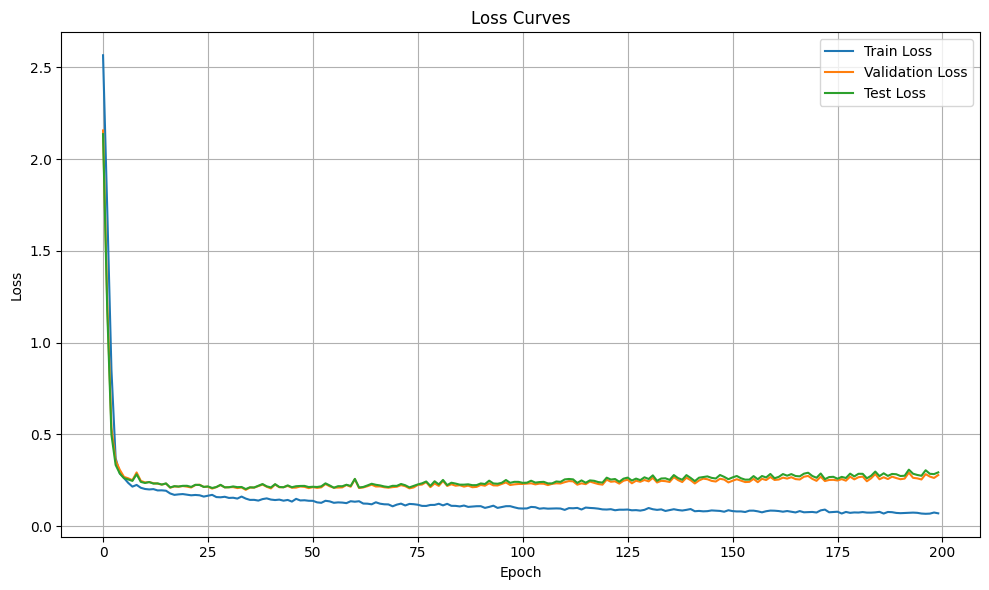

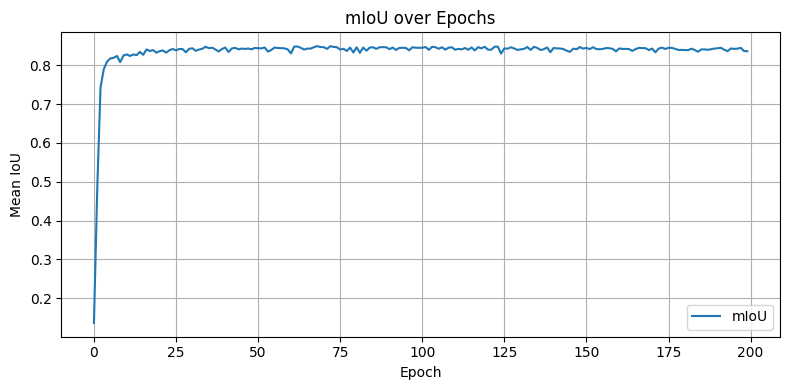

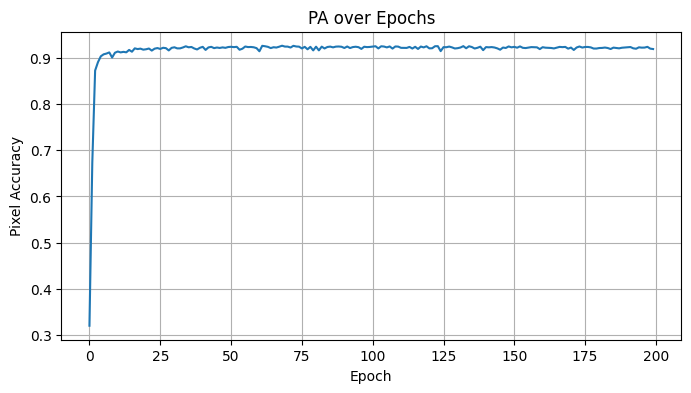

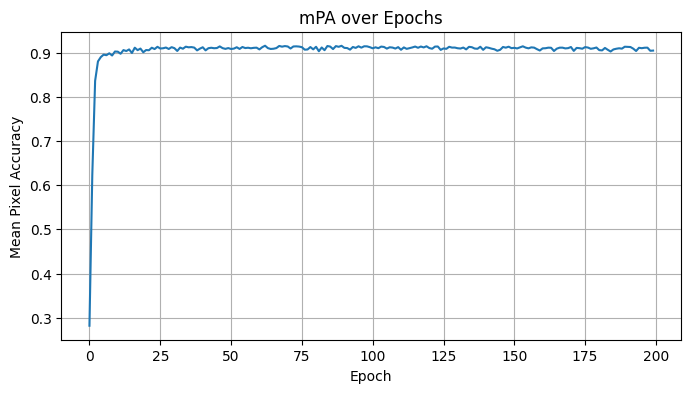

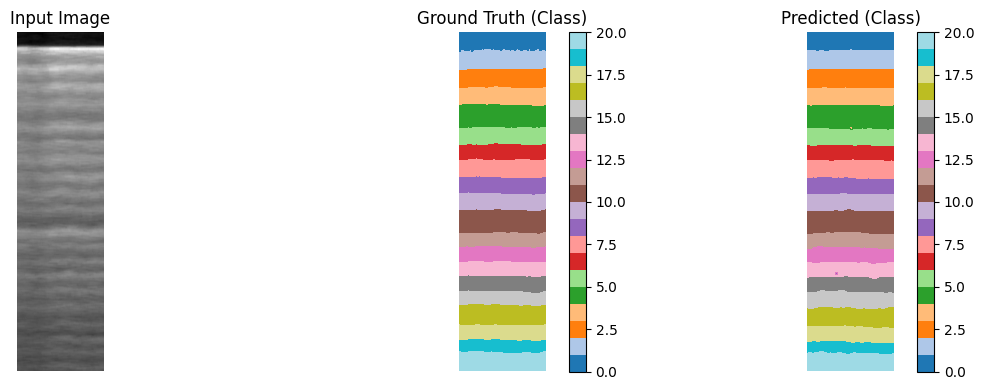

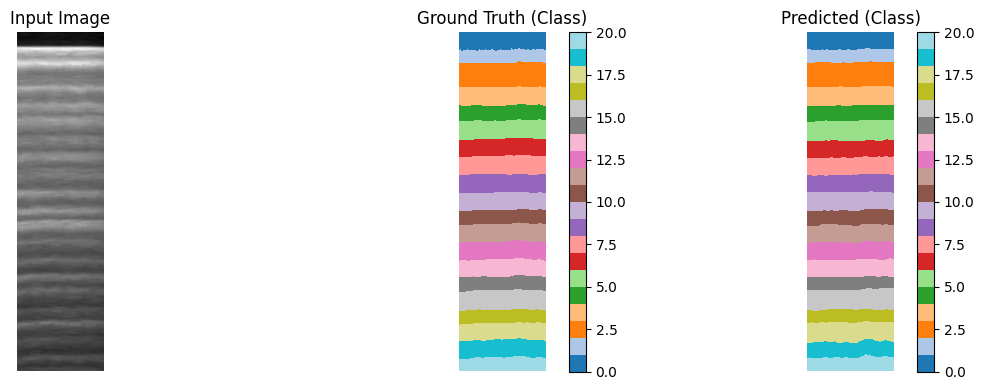

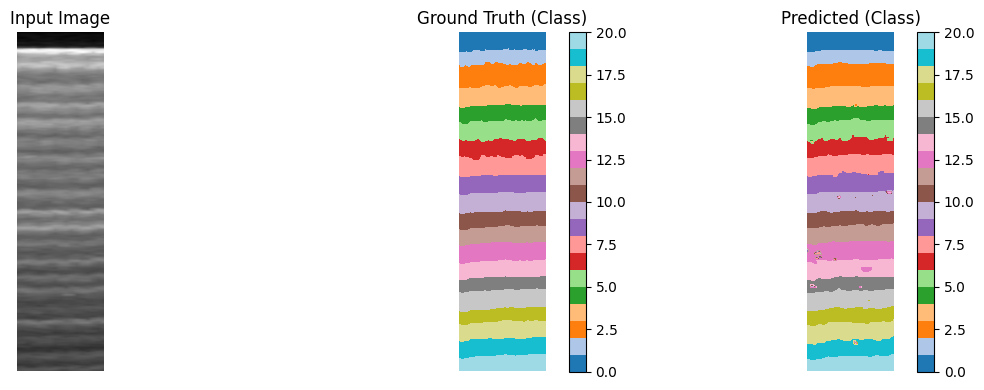

In [25]:
# @title early, in model, mlp&cnn


class FusionDualInputDataset(Dataset):
    def __init__(self, data, mask, layer_x, H):
        self.data = torch.from_numpy(data).float()     # (N, 1, H, W)
        self.mask = torch.from_numpy(mask).long()      # (N, 1, H, W)
        self.layer_x = torch.from_numpy(layer_x).float()  # (N, 5, W)
        self.H = H

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img = self.data[idx]     # (1, H, W)
        mask = self.mask[idx]    # (1, H, W)
        layer_coords = self.layer_x[idx]  # (5, W)

        return img, layer_coords, mask

class DualInputSegNet(nn.Module):
    def __init__(self, H, W):
        super(DualInputSegNet, self).__init__()
        self.H = H
        self.W = W

        # 处理 5 层输入 (B, 5, W)
        self.fc = nn.Linear(W, H * W)  # 扩展到 H x W
        self.bn_fc = nn.BatchNorm1d(5)

        # CNN for fused features
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 21, 1)
        )

    def forward(self, img, layer_x):
        # img: (B, 1, H, W)
        # layer_x: (B, 5, W)

        B = layer_x.shape[0]

        # 1. 处理 5 层信息，拓展成 (B, 5, H, W)
        layer_x = self.bn_fc(layer_x)  # BatchNorm over features
        layer_feat = self.fc(layer_x)  # (B, 5, H*W)
        layer_feat = layer_feat.view(B, 5, self.H, self.W)  # (B, 5, H, W)

        # 2. 融合两个输入
        fused = torch.cat([img, layer_feat], dim=1)  # (B, 6, H, W)

        # 3. 分割网络
        x = self.encoder(fused)
        out = self.decoder(x)

        return out#.squeeze(1)  # (B, 1, H, W) → (B, H, W)


N = data.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

train_size = int(0.6 * N)
val_size = int(0.2 * N)
test_size = N - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]
dataset = FusionDualInputDataset(data, mask, layer_x, H=1000)
#dataset = FusionDataset1(data, mask, layer_x, H=1000)
#dataset = FusionDatasetCached(data, mask, smoothed_layer_masks)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,drop_last = True)


model = DualInputSegNet(H=1000, W=256).to(DEVICE)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb_img, xb_layer, yb in train_loader:
        xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
        pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in val_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in test_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
            pa_total += pa
            mpa_total += mpa
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break





plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)

plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_fusion_sample_cls(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()


[Epoch 1/200] Train Loss: 1.0273, Val Loss: 1.6869，Test Loss: 1.6749, miou:0.7218,pa:0.8608,mpa:0.8206
[Epoch 1] New best model saved (Val Loss: 1.6869)
[Epoch 2/200] Train Loss: 0.2969, Val Loss: 0.2390，Test Loss: 0.2387, miou:0.8242,pa:0.9138,mpa:0.8986
[Epoch 2] New best model saved (Val Loss: 0.2390)
[Epoch 3/200] Train Loss: 0.2246, Val Loss: 0.2071，Test Loss: 0.2092, miou:0.8302,pa:0.9186,mpa:0.9001
[Epoch 3] New best model saved (Val Loss: 0.2071)
[Epoch 4/200] Train Loss: 0.2005, Val Loss: 0.1883，Test Loss: 0.1932, miou:0.8416,pa:0.9235,mpa:0.9103
[Epoch 4] New best model saved (Val Loss: 0.1883)
[Epoch 5/200] Train Loss: 0.1879, Val Loss: 0.1826，Test Loss: 0.1827, miou:0.8492,pa:0.9267,mpa:0.9158
[Epoch 5] New best model saved (Val Loss: 0.1826)
[Epoch 6/200] Train Loss: 0.1802, Val Loss: 0.1776，Test Loss: 0.1774, miou:0.8528,pa:0.9286,mpa:0.9173
[Epoch 6] New best model saved (Val Loss: 0.1776)
[Epoch 7/200] Train Loss: 0.1700, Val Loss: 0.1691，Test Loss: 0.1709, miou:0.8579,

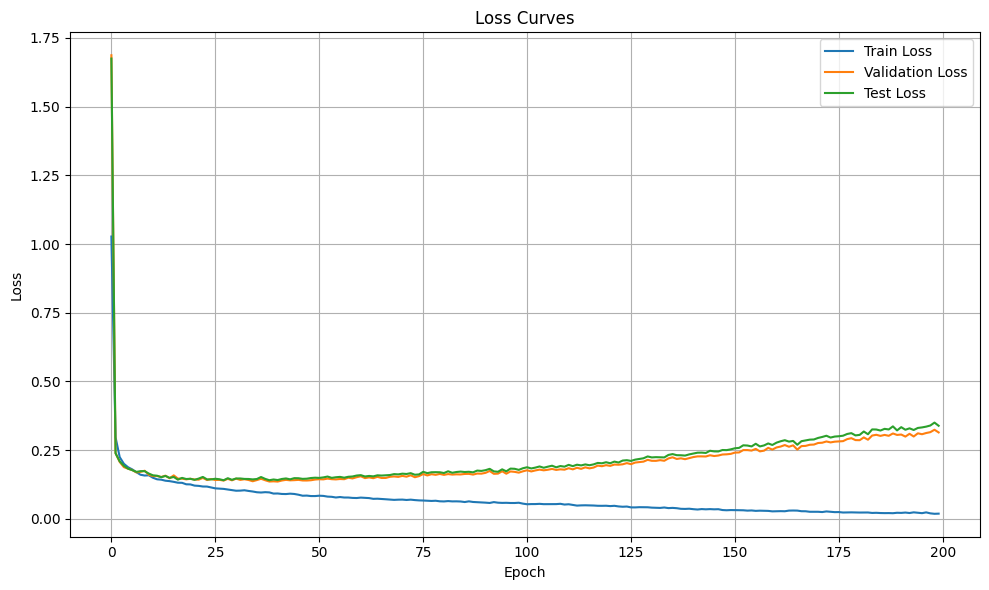

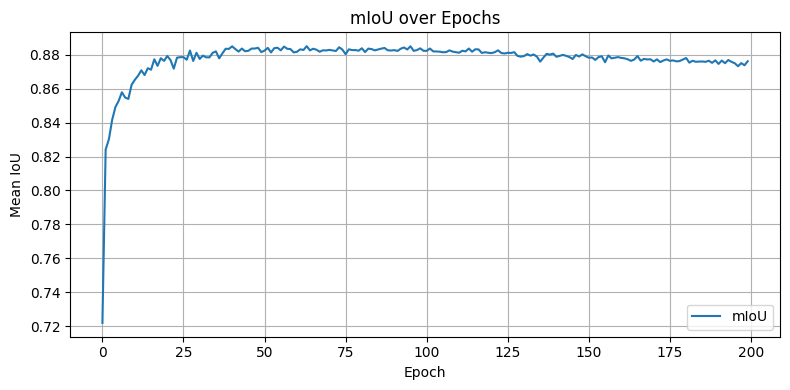

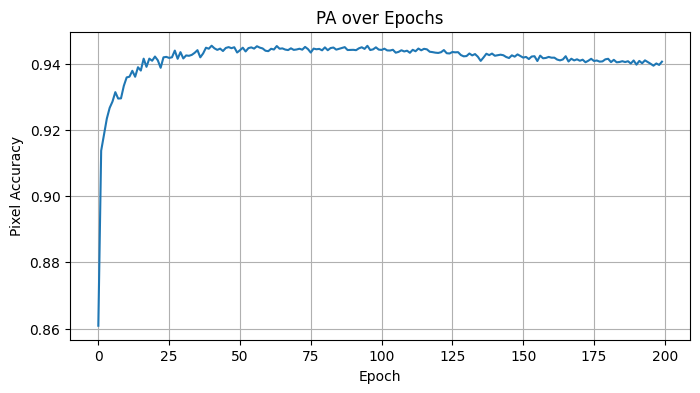

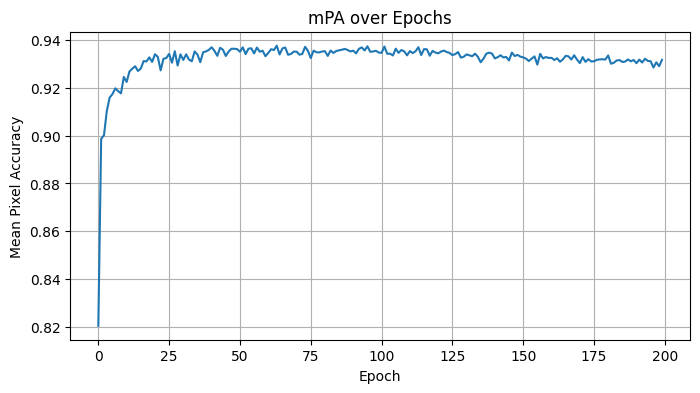

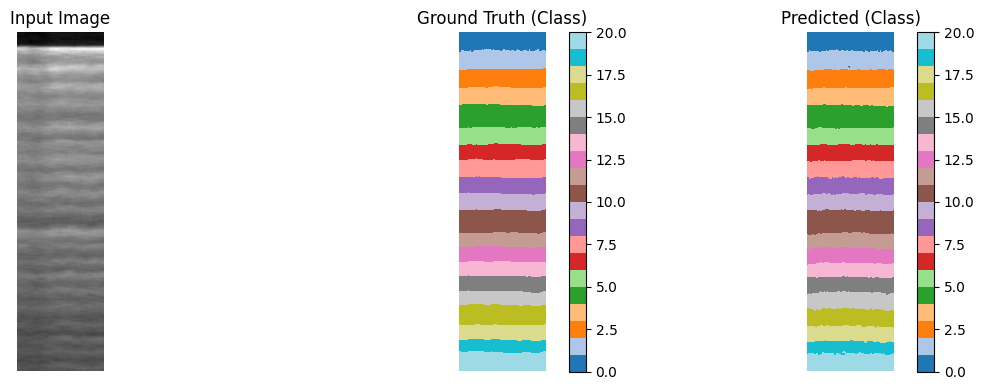

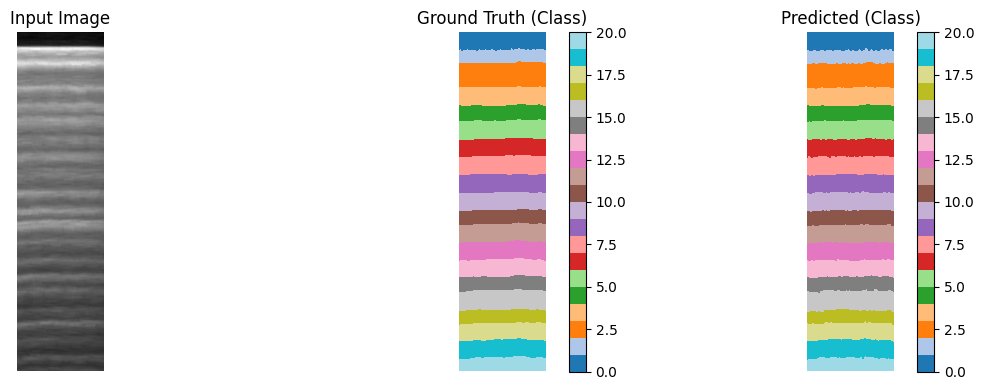

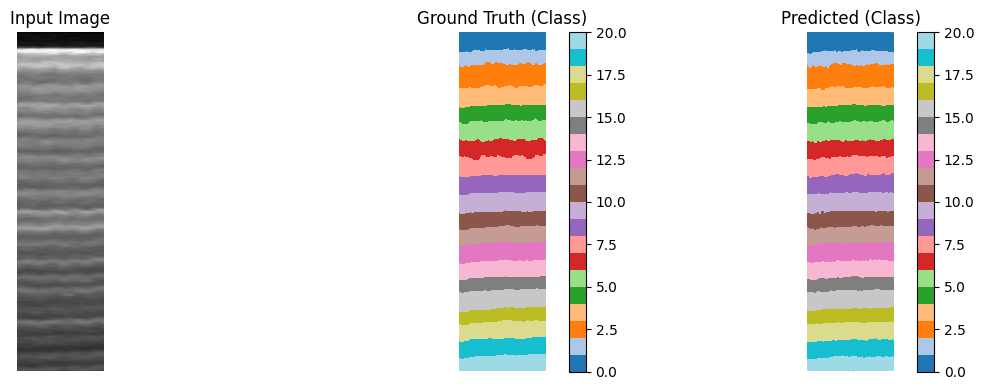

In [26]:
# @title early, in model, mlp&fno


class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.bn = nn.BatchNorm2d(out_channels)
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #print('x',x.shape)
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #x_ft = torch.fft.rfft(x, 2, normalized=True, onesided=True)#old version
        x_ft = torch.fft.rfft2(x)#new version

        # Multiply relevant Fourier modes
        #print('x_ft',x_ft.shape)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))#old version
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))#new version
        x = self.bn(x)
        return x

class DualFNOBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, width,H,W):
        super(DualFNOBlock2d, self).__init__()

        self.H = H
        self.W = W

        # 处理 5 层输入 (B, 5, W)
        self.fc = nn.Linear(W, H * W)  # 扩展到 H x W
        self.bn_fc = nn.BatchNorm1d(5)
        self.width = width
        self.in_proj = nn.Conv2d(in_channels, width, 1)  # Lift to width channels

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        #self.conv3 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        #self.w3 = nn.Conv2d(width, width, 1)

        self.out_proj = nn.Conv2d(width, out_channels, 1)  # Back to 1 channel for regression

    def forward(self, x,layer_x):
        B = layer_x.shape[0]

        # 1. 处理 5 层信息，拓展成 (B, 5, H, W)
        layer_x = self.bn_fc(layer_x)  # BatchNorm over features
        layer_feat = self.fc(layer_x)  # (B, 5, H*W)
        layer_feat = layer_feat.view(B, 5, self.H, self.W)  # (B, 5, H, W)

        # 2. 融合两个输入
        fused = torch.cat([x, layer_feat], dim=1)  # (B, 6, H, W)

        x = self.in_proj(fused)  # (B, width, H, W)

        x1 = self.conv0(x) + self.w0(x)
        x = F.relu(x1)

        x1 = self.conv1(x) + self.w1(x)
        x = F.relu(x1)

        x1 = self.conv2(x) + self.w2(x)
        x = F.relu(x1)

        #x1 = self.conv3(x) + self.w3(x)
        #x = F.relu(x1)

        out = self.out_proj(x)  # (B, 1, H, W)
        return out#.squeeze(1)  # (B, 1, H, W) → (B, H, W)



model = DualFNOBlock2d(in_channels=6, out_channels=NUM_CLASSES, modes1=16, modes2=16, width=32,H = 1000,W = 256).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb_img, xb_layer, yb in train_loader:
        xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
        pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in val_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in test_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
            pa_total += pa
            mpa_total += mpa
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break





plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)

plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_fusion_sample_cls(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 1.8884, Val Loss: 0.9482，Test Loss: 0.9321, miou:0.5817,pa:0.7506,mpa:0.7199
[Epoch 1] New best model saved (Val Loss: 0.9482)
[Epoch 2/200] Train Loss: 0.6146, Val Loss: 0.4887，Test Loss: 0.4698, miou:0.7102,pa:0.8516,mpa:0.8180
[Epoch 2] New best model saved (Val Loss: 0.4887)
[Epoch 3/200] Train Loss: 0.3879, Val Loss: 0.3995，Test Loss: 0.3826, miou:0.7506,pa:0.8653,mpa:0.8541
[Epoch 3] New best model saved (Val Loss: 0.3995)
[Epoch 4/200] Train Loss: 0.3240, Val Loss: 0.3489，Test Loss: 0.3323, miou:0.7676,pa:0.8760,mpa:0.8669
[Epoch 4] New best model saved (Val Loss: 0.3489)
[Epoch 5/200] Train Loss: 0.3000, Val Loss: 0.3156，Test Loss: 0.3049, miou:0.7728,pa:0.8804,mpa:0.8660
[Epoch 5] New best model saved (Val Loss: 0.3156)
[Epoch 6/200] Train Loss: 0.2861, Val Loss: 0.3180，Test Loss: 0.3035, miou:0.7778,pa:0.8829,mpa:0.8758
[Epoch 7/200] Train Loss: 0.2807, Val Loss: 0.3012，Test Loss: 0.2883, miou:0.7823,pa:0.8868,mpa:0.8708
[Epoch 7] New best model save

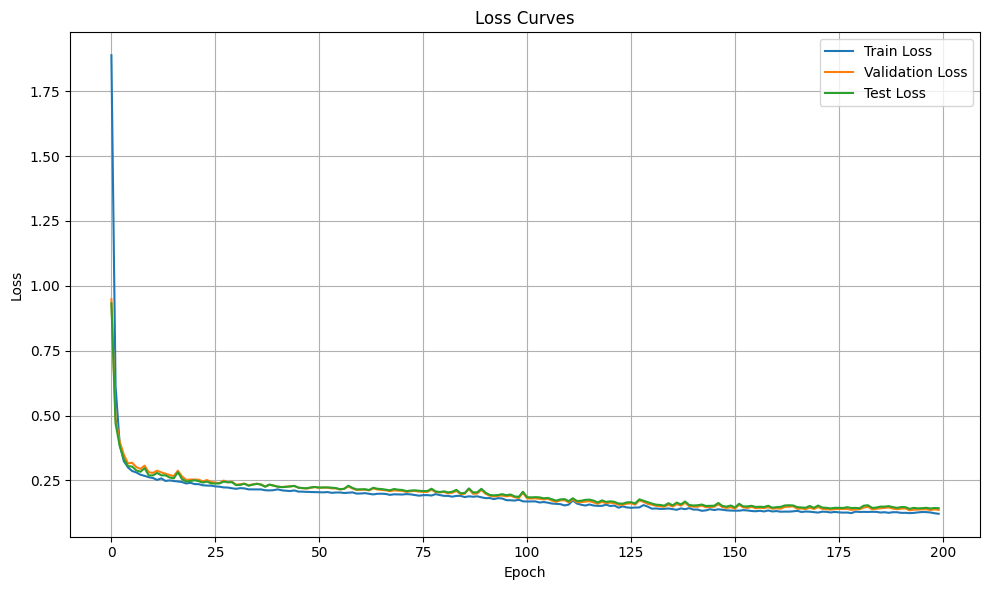

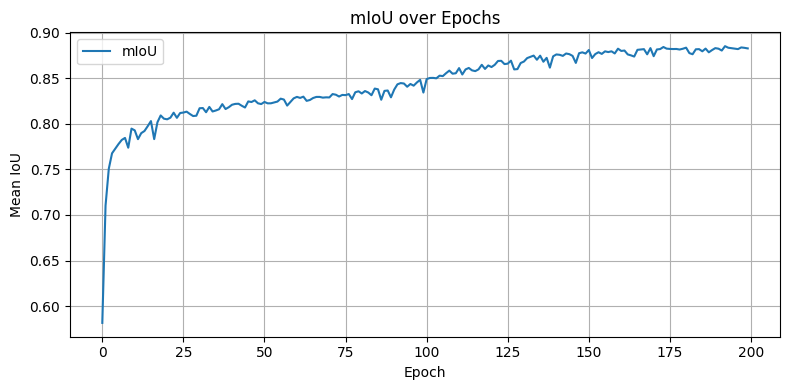

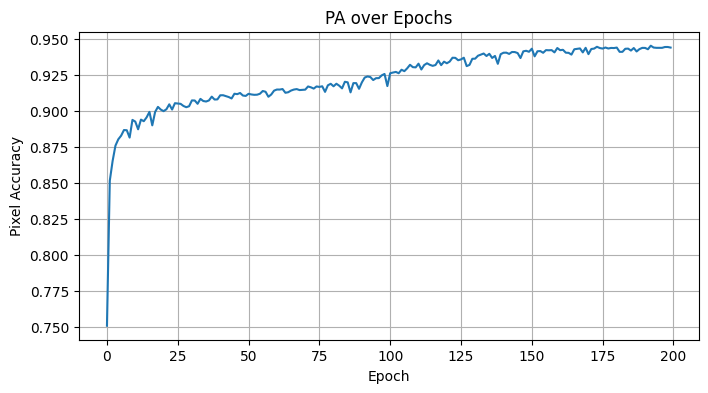

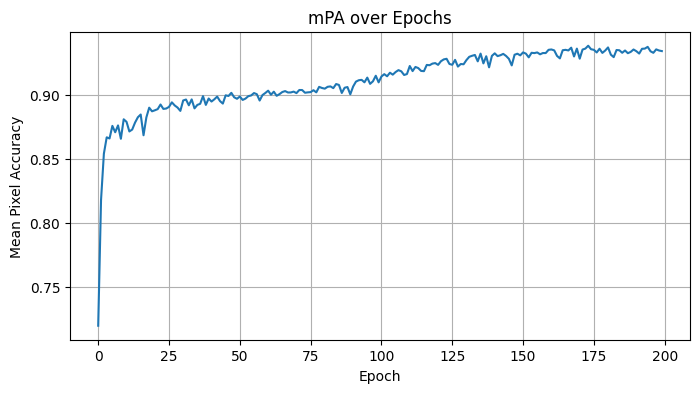

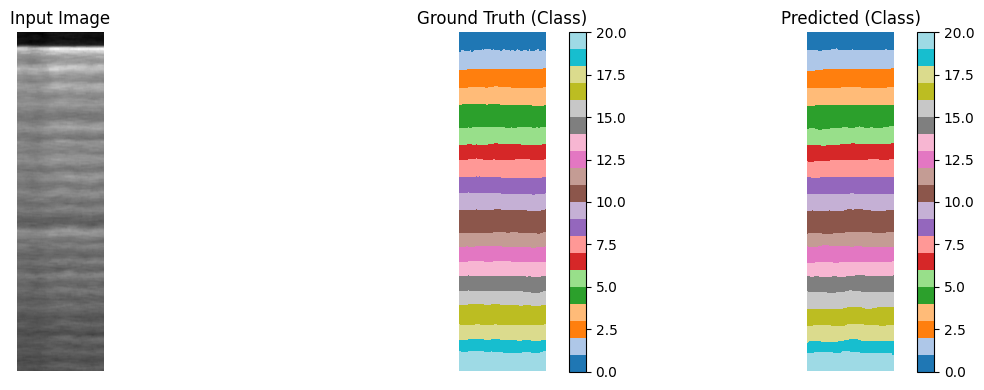

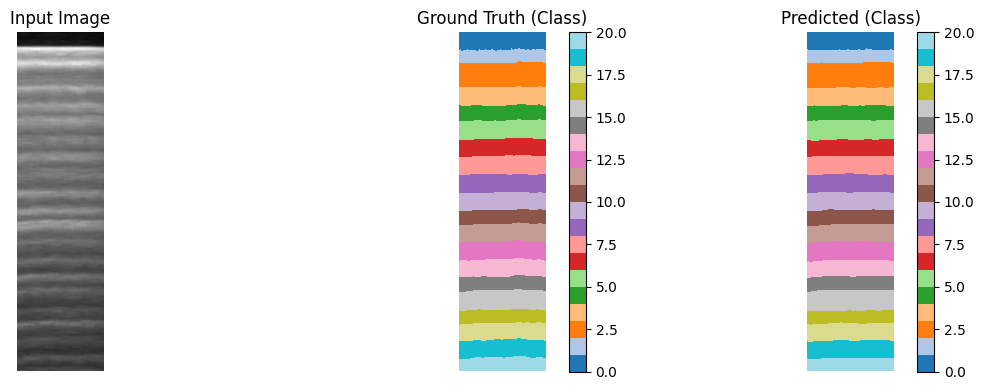

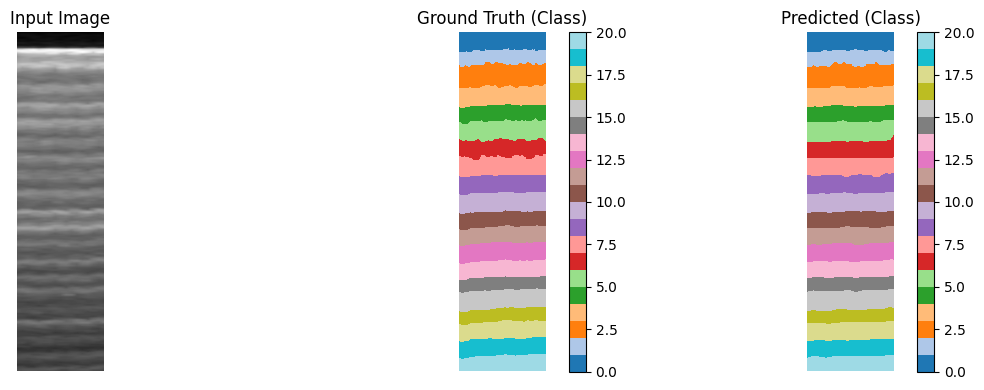

In [27]:
# @title early, in model, mlp(c=1)&cnn

class EarlyFusionMLPNet(nn.Module):
    def __init__(self, H=1000, W=256):
        super(EarlyFusionMLPNet, self).__init__()
        self.H = H
        self.W = W

        # MLP 展开层信息
        self.mlp = nn.Sequential(
            nn.Linear(5, 128), nn.ReLU(),
            nn.Linear(128, H)  # 输出大小为 H
        )

        # CNN 分割网络
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # (B, 16, 500, 128)
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # (B, 32, 250, 64)
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # (B, 64, 125, 32)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 21, 1)  # 回归输出
        )

    def forward(self, img, layer_x):
        # img: (B, 1, H, W)
        # layer_x: (B, 5, W)

        B = layer_x.shape[0]

        # 1️⃣ MLP 展成 (B, 1, H, W)
        layer_feat = self.mlp(layer_x.permute(0, 2, 1))  # (B, 256, H)
        layer_feat = layer_feat.permute(0, 2, 1).unsqueeze(1)  # (B, 1, H, W)

        # 2️⃣ 拼接通道 (B, 2, H, W)
        fused = torch.cat([img, layer_feat], dim=1)

        # 3️⃣ CNN 处理
        x = self.encoder(fused)
        out = self.decoder(x)  # (B, 1, H, W)
        return out#.squeeze(1)  # (B, H, W)


model = EarlyFusionMLPNet().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb_img, xb_layer, yb in train_loader:
        xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
        pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in val_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in test_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
            pa_total += pa
            mpa_total += mpa
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break





plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)

plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_fusion_sample_cls(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()


[Epoch 1/200] Train Loss: 2.7499, Val Loss: 2.2050，Test Loss: 2.1983, miou:0.1381,pa:0.3179,mpa:0.2905
[Epoch 1] New best model saved (Val Loss: 2.2050)
[Epoch 2/200] Train Loss: 1.5551, Val Loss: 1.0600，Test Loss: 1.0434, miou:0.5542,pa:0.7294,mpa:0.6977
[Epoch 2] New best model saved (Val Loss: 1.0600)
[Epoch 3/200] Train Loss: 0.8147, Val Loss: 0.6570，Test Loss: 0.6380, miou:0.7018,pa:0.8310,mpa:0.8192
[Epoch 3] New best model saved (Val Loss: 0.6570)
[Epoch 4/200] Train Loss: 0.5123, Val Loss: 0.4581，Test Loss: 0.4374, miou:0.7387,pa:0.8584,mpa:0.8426
[Epoch 4] New best model saved (Val Loss: 0.4581)
[Epoch 5/200] Train Loss: 0.3993, Val Loss: 0.4098，Test Loss: 0.3924, miou:0.7432,pa:0.8611,mpa:0.8478
[Epoch 5] New best model saved (Val Loss: 0.4098)
[Epoch 6/200] Train Loss: 0.3562, Val Loss: 0.3692，Test Loss: 0.3534, miou:0.7526,pa:0.8675,mpa:0.8522
[Epoch 6] New best model saved (Val Loss: 0.3692)
[Epoch 7/200] Train Loss: 0.3371, Val Loss: 0.3650，Test Loss: 0.3474, miou:0.7526,

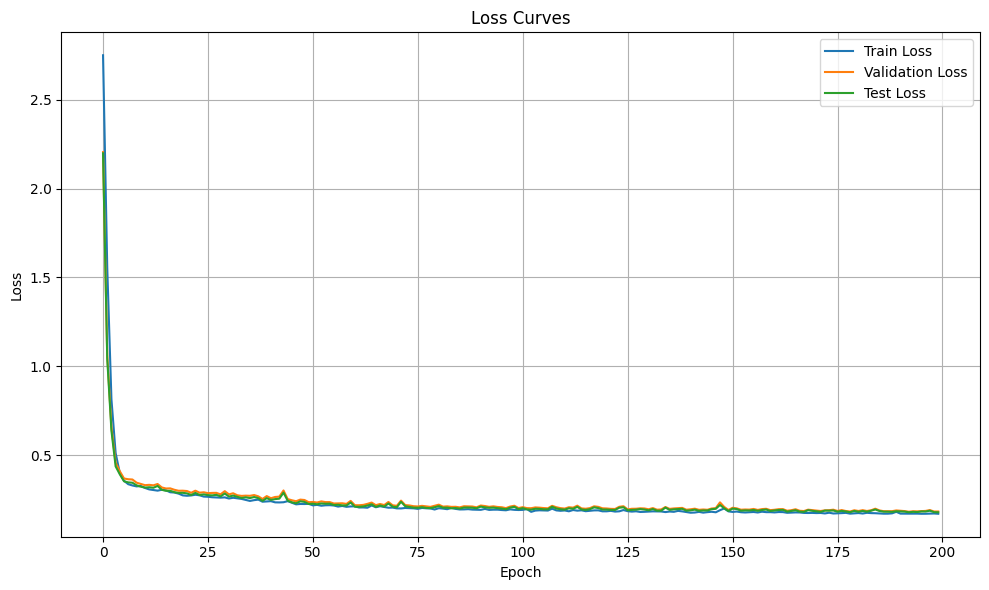

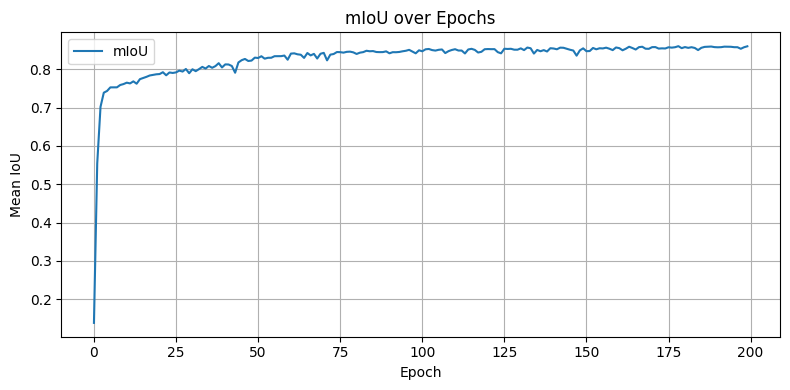

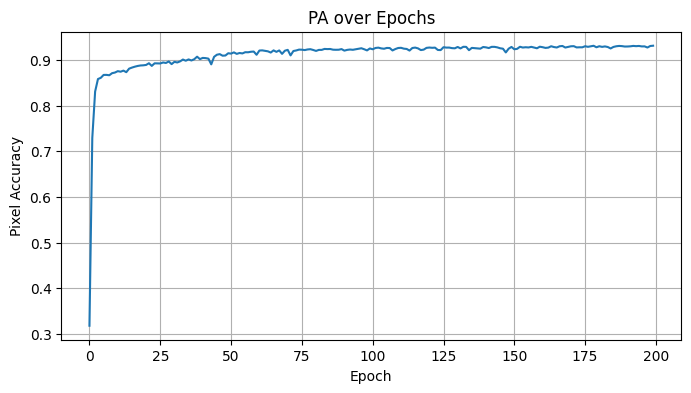

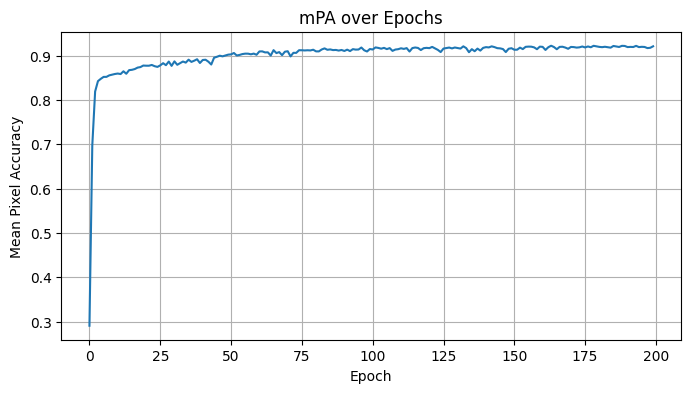

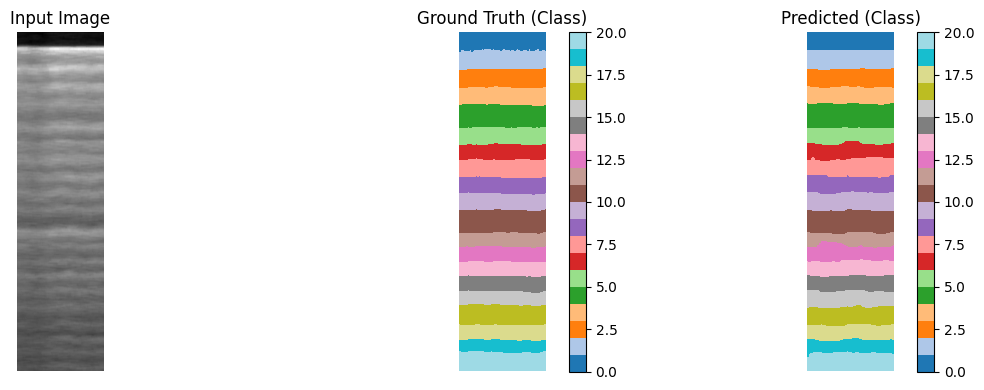

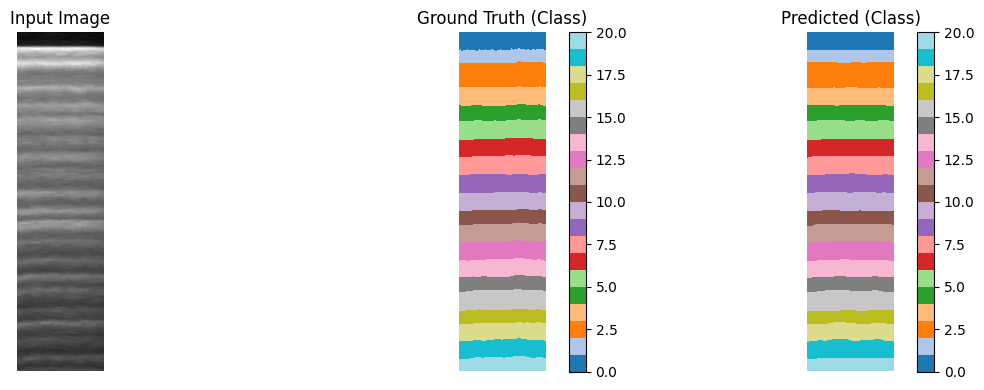

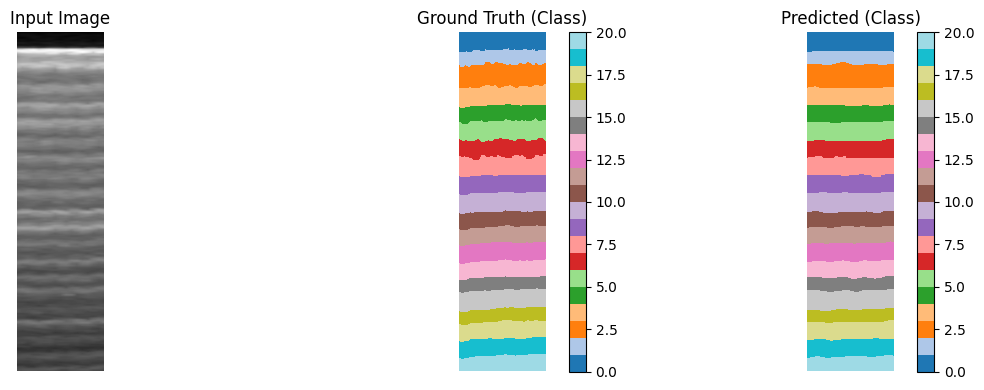

In [28]:
# @title early, in model, transformer(c=1)&cnn
class LayerTransformerExpand(nn.Module):
    def __init__(self, seq_len=256, embed_dim=128, num_heads=4, num_layers=2, target_H=1000):
        super(LayerTransformerExpand, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=seq_len, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_expand = nn.Linear(5, target_H)

    def forward(self, x):
        # x: (B, 5, 256)
        B = x.shape[0]

        # Apply transformer across 5 layers (tokens)
        x = self.transformer(x)  # (B, 5, 256)

        # Expand 5 → H (1000), dim-wise
        x = x.permute(0, 2, 1)  # (B, 256, 5)
        x = self.fc_expand(x)   # (B, 256, 1000)
        x = x.permute(0, 2, 1).unsqueeze(1)  # (B, 1, 1000, 256)
        return x
class EarlyFusionTransformerNet(nn.Module):
    def __init__(self, H=1000, W=256):
        super(EarlyFusionTransformerNet, self).__init__()
        self.layer_transformer = LayerTransformerExpand(seq_len=W, target_H=H)

        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 21, 1)  # regression output
        )

    def forward(self, img, layer_x):
        # img: (B, 1, 1000, 256)
        # layer_x: (B, 5, 256)
        layer_feat = self.layer_transformer(layer_x)  # (B, 1, 1000, 256)

        fused = torch.cat([img, layer_feat], dim=1)  # (B, 2, 1000, 256)
        x = self.encoder(fused)
        out = self.decoder(x)  # (B, 1, 1000, 256)
        return out#.squeeze(1)  # (B, 1000, 256)


model = EarlyFusionTransformerNet().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb_img, xb_layer, yb in train_loader:
        xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
        pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in val_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in test_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
            pa_total += pa
            mpa_total += mpa
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break





plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)

plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_fusion_sample_cls(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()

[Epoch 1/200] Train Loss: 1.5010, Val Loss: 1.8909，Test Loss: 1.8858, miou:0.5407,pa:0.7317,mpa:0.6794
[Epoch 1] New best model saved (Val Loss: 1.8909)
[Epoch 2/200] Train Loss: 0.3072, Val Loss: 0.3119，Test Loss: 0.3105, miou:0.7618,pa:0.8784,mpa:0.8577
[Epoch 2] New best model saved (Val Loss: 0.3119)
[Epoch 3/200] Train Loss: 0.2318, Val Loss: 0.2535，Test Loss: 0.2502, miou:0.8035,pa:0.9010,mpa:0.8843
[Epoch 3] New best model saved (Val Loss: 0.2535)
[Epoch 4/200] Train Loss: 0.2096, Val Loss: 0.2199，Test Loss: 0.2204, miou:0.8250,pa:0.9127,mpa:0.9017
[Epoch 4] New best model saved (Val Loss: 0.2199)
[Epoch 5/200] Train Loss: 0.1940, Val Loss: 0.2174，Test Loss: 0.2172, miou:0.8253,pa:0.9130,mpa:0.8987
[Epoch 5] New best model saved (Val Loss: 0.2174)
[Epoch 6/200] Train Loss: 0.1855, Val Loss: 0.2023，Test Loss: 0.2033, miou:0.8342,pa:0.9176,mpa:0.9085
[Epoch 6] New best model saved (Val Loss: 0.2023)
[Epoch 7/200] Train Loss: 0.1748, Val Loss: 0.1868，Test Loss: 0.1910, miou:0.8433,

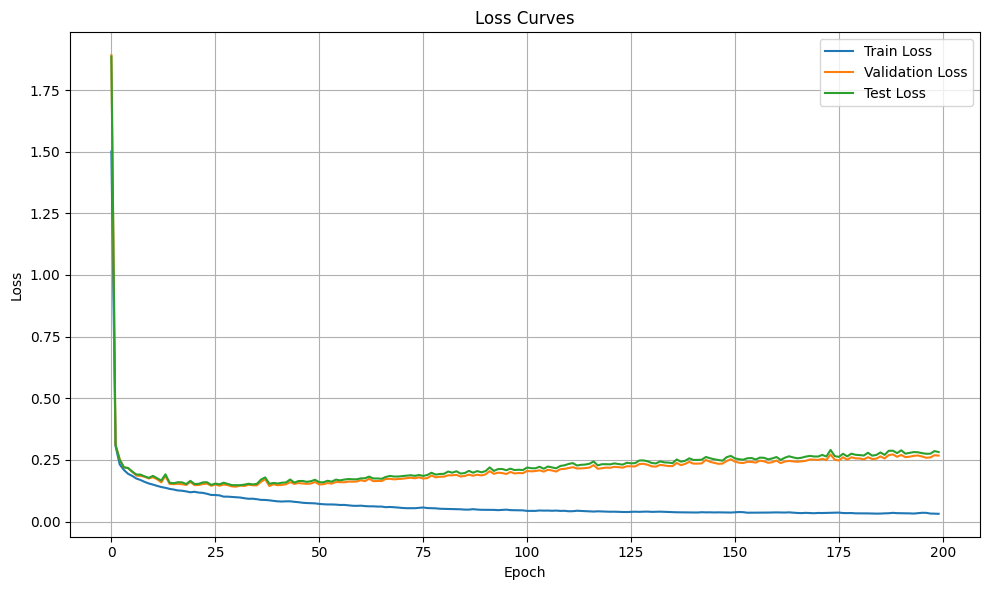

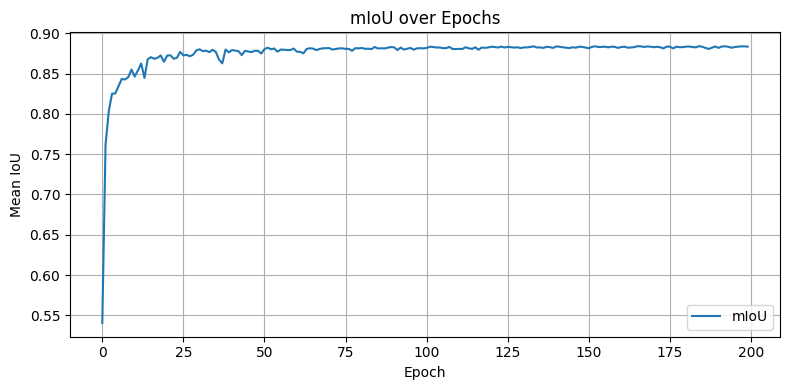

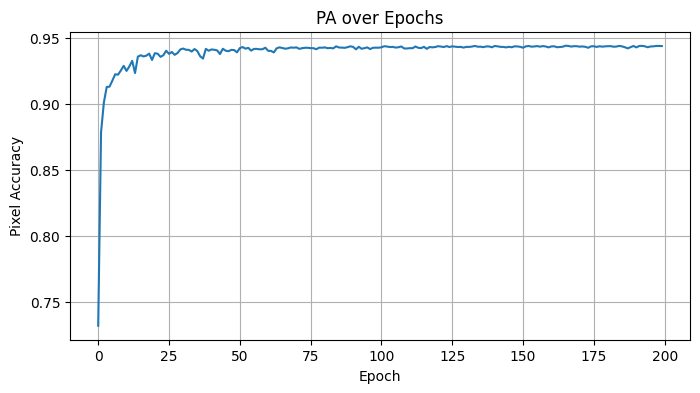

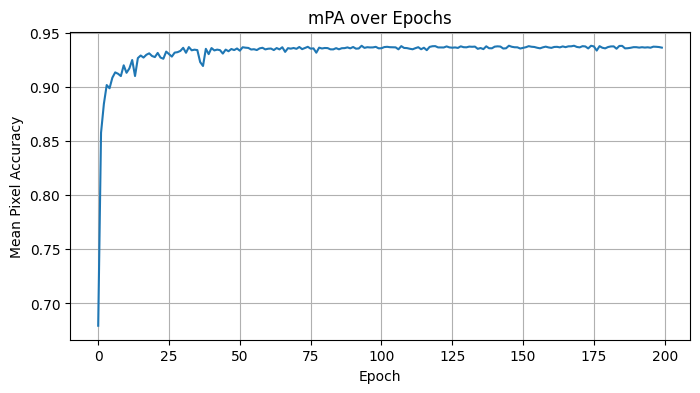

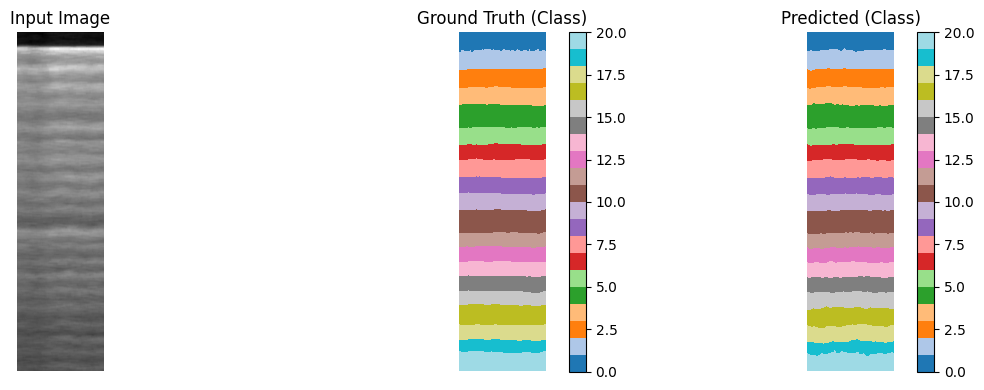

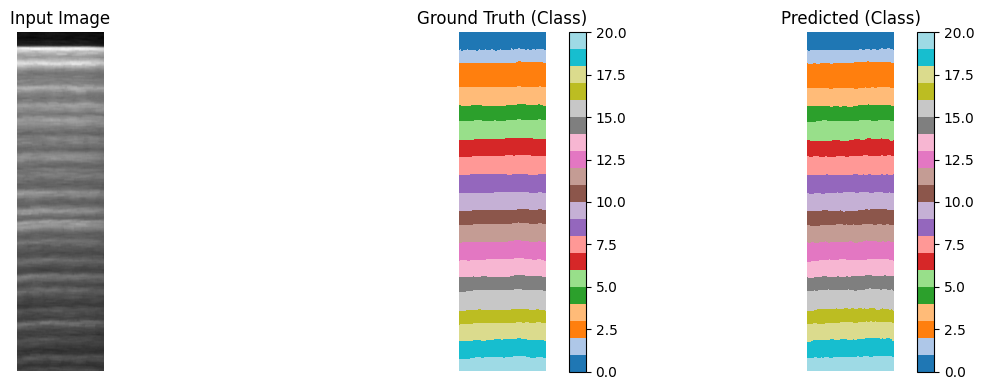

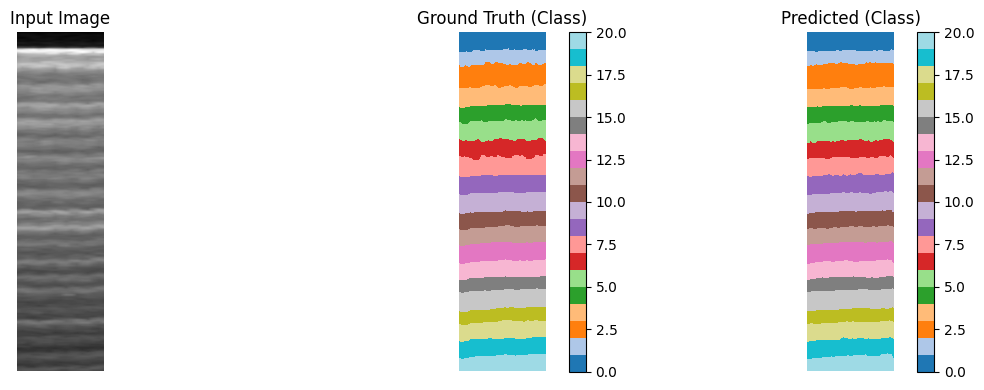

In [29]:
# @title early, in model, transformer(c=1)&fno
class TransformerFNOFusionNet(nn.Module):
    def __init__(self, H=1000, W=256, modes1=16, modes2=16, width=32):
        super(TransformerFNOFusionNet, self).__init__()
        self.H = H
        self.W = W

        # Transformer for Layer Info
        self.layer_transformer = nn.Sequential(
            nn.LayerNorm(W),
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=W, nhead=4, batch_first=True),
                num_layers=2
            )
        )
        self.fc_expand = nn.Linear(5, H)

        # Initial projection
        self.fc0 = nn.Linear(2, width)  # 2通道：图像 + 展开层信息

        # 4 层 FNO
        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)

        # Output projection
        self.fc1 = nn.Conv2d(width, 64, 1)
        self.fc2 = nn.Conv2d(64, 21, 1)

    def forward(self, img, layer_x):
        B = layer_x.shape[0]

        # Transformer 处理层信息
        layer_x = self.layer_transformer(layer_x)  # (B, 5, 256)
        layer_feat = layer_x.permute(0, 2, 1)  # (B, 256, 5)
        layer_feat = self.fc_expand(layer_feat)  # (B, 256, 1000)
        layer_feat = layer_feat.permute(0, 2, 1).unsqueeze(1)  # (B, 1, 1000, 256)

        # 拼接
        fused = torch.cat([img, layer_feat], dim=1)  # (B, 2, 1000, 256)

        # 初始映射
        x = fused.permute(0, 2, 3, 1)  # (B, H, W, 2)
        x = self.fc0(x)  # (B, H, W, width)
        x = x.permute(0, 3, 1, 2)  # (B, width, H, W)

        # 4 层 FNO
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = F.relu(x1 + x2)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = F.relu(x1 + x2)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = F.relu(x1 + x2)

        # Output
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # (B, 21, H, W)

        return x


model = TransformerFNOFusionNet().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
train_losses = []
val_losses = []
test_losses = []
miou_curve = []
pa_curve = []
mpa_curve = []

best_val_loss = float('inf')
best_model_state = None


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_count = 0
    val_count = 0
    test_count = 0
    miou_total = 0
    pa_total = 0
    mpa_total = 0
    for xb_img, xb_layer, yb in train_loader:
        xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
        pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_count += 1

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in val_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
            val_count += 1

    test_loss = 0
    with torch.no_grad():
        for xb_img, xb_layer, yb in test_loader:
            xb_img, xb_layer, yb = xb_img.to(DEVICE), xb_layer.to(DEVICE), yb.to(DEVICE).squeeze(1)
            pred = model(xb_img, xb_layer)  # (B, num_classes, H, W)
            loss = loss_fn(pred, yb)
            pa, mpa = compute_pixel_accuracy(pred, yb, num_classes=21)
            test_loss += loss.item()
            miou = compute_miou(pred, yb, num_classes=21)
            miou_total += miou
            pred_biou = torch.argmax(pred, dim=1)  # for CE classification output

            test_count += 1
            pa_total += pa
            mpa_total += mpa
    miou = miou_total / test_count
    pa = pa_total / test_count
    mpa = mpa_total / test_count
    train_losses.append(train_loss / train_count)
    val_losses.append(val_loss / val_count)
    test_losses.append(test_loss / test_count)
    miou_curve.append(miou)
    pa_curve.append(pa)
    mpa_curve.append(mpa)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss / train_count:.4f}, Val Loss: {val_loss / val_count:.4f}，Test Loss: {test_loss / test_count:.4f}, miou:{miou:.4f},pa:{pa:.4f},mpa:{mpa:.4f}")
    early_stopper.step(val_loss / val_count)
    if val_loss/val_count < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss/val_count
        best_model_state = copy.deepcopy(model.state_dict())  # save the weights
        print(f"[Epoch {epoch+1}] New best model saved (Val Loss: {val_loss/val_count:.4f})")
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break





plot_all_losses(train_losses, val_losses, test_losses)
plt.figure(figsize=(8, 4))
plt.plot(miou_curve, label='mIoU')
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("mIoU over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pa_curve, label='PA')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("PA over Epochs")
plt.grid(True)

plt.figure(figsize=(8, 4))
plt.plot(mpa_curve, label='mPA')
plt.xlabel("Epoch")
plt.ylabel("Mean Pixel Accuracy")
plt.title("mPA over Epochs")
plt.grid(True)

visualize_fusion_sample_cls(model, test_loader, DEVICE, max_samples=3)
del model, optimizer, loss_fn  # 删除引用
gc.collect()
torch.cuda.empty_cache()